# CCF DL

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import os
import pickle
from tqdm import trange

from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression


import lightgbm as lgb
from lightgbm import plot_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import Normalizer
from sklearn.metrics import classification_report

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingClassifier

from catboost import CatBoostClassifier

import seaborn as sns
sns.set(style='darkgrid')
colors = ['#EE5622', '#FCBD51', '#836EA3', '#B1ACB8', '#D9CDEC', '#6E23C9', '#EF7A7A', '#EFBFA0']# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
import warnings
warnings.filterwarnings("ignore")

# Данные
path = 'D:\Work_dir\Master_work\Data\Bank_Account_Fraud_Dataset_Suite'
path_ccf = "D:\Work_dir\Master_work\Data\Credit_Card_Fraud_Detection"
# Папка с сохраненными  моделями
m_baf_path = 'BAF_DL_models'
m_ccf_path = 'CCF_DL_models'

In [84]:
%matplotlib inline

In [9]:
# Поместим эту функцию в спомогательный файл
from base import data, metrics

In [10]:
!nvidia-smi

Thu May  4 22:59:30 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.14                 Driver Version: 531.14       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090       WDDM | 00000000:01:00.0  On |                  N/A |
|  0%   39C    P8               29W / 350W|   6184MiB / 24576MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import torch
from torch import nn
from torcheval.metrics import BinaryAccuracy#, BinaryRecall
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam, SGD
batch_size = 64
from torchmetrics.classification import BinaryRecall

In [4]:
from IPython.display import clear_output

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
DEVICE

device(type='cuda')

# Подготовка данных

In [8]:
X_train, y_train, X_val, y_val, X_test, y_test = data.prep_data_baf(path)

In [9]:
train_dataset = TensorDataset(
              torch.tensor(X_train.astype(np.float32)),
              torch.tensor(y_train.values.astype(np.float32)))

val_dataset = TensorDataset(
              torch.tensor(X_val.astype(np.float32)),
              torch.tensor(y_val.values.astype(np.float32)))

test_dataset = TensorDataset(
              torch.tensor(X_test.astype(np.float32)),
              torch.tensor(y_test.values.astype(np.float32)))

In [10]:
# Даталодер
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Попробуем AE (Автоэнкодер)

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
          nn.Linear(input_size, 3904),
          nn.ReLU(),
          nn.Linear(3904, 512),
          nn.ReLU(),
          nn.Linear(512, 64),
          nn.ReLU(),
          nn.Linear(64, 16),
          nn.ReLU(),
        )
        self.decoder_body = nn.Sequential(
          nn.Linear(16, 64),
          nn.ReLU(),
          nn.Linear(64, 512),
          nn.ReLU(),
          nn.Linear(512, 3904),
          nn.ReLU()
        )
        # Определим голову Decoder
        self.decoder_head = nn.Linear(3904, input_size)
        
        # Определим голову для обучения классификатора
        self.classifier_head = nn.Sequential(
            nn.Linear(3904, 2),
            nn.Softmax(dim=1),
            )

    def forward(self, x):
        enc = self.encoder(x)
        dec_body = self.decoder_body(enc)
        
        dec_head = self.decoder_head(dec_body)
        clf_head = torch.argmax(self.classifier_head(dec_body), dim=1)
        
        return dec_head, clf_head

In [12]:
sample_size = X_train.shape[1]
lr = 1e-3

In [13]:
model = Autoencoder(sample_size).to(DEVICE)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)
# Обучим 20 эпох
epochs = 20

# <span style='background-color: #D6F99B'>Приступим к обучению </span>

In [14]:
def plot_results(loss_history_AE, loss_history_clf):
    iters = len(loss_history_AE)
    x = np.arange(1, iters+1)
    # Визуализируем полученные данные

    plt.figure(figsize=[5, 10])
    plt.subplot(2, 1, 1)
    plt.title("Mean AE loss")
    plt.plot(x, loss_history_AE)
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.title("Mean CLF loss")
    plt.plot(x, loss_history_clf)
    plt.grid()
    plt.show()

In [15]:
def train(model, criterion, optimizer, epochs):

    loss_AE_history, loss_CLF_history = [], []

    for epoch in trange(epochs):
        running_loss, clf_running = 0, 0
        for (x_batch, y_batch) in train_loader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            
            dec_head, clf_head = model(x_batch)
            # Ошибка для AE
            loss = criterion(dec_head, x_batch)
            # Ошибка для CLF
            #print(clf_head, y_batch)
            loss_clf = criterion(clf_head, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            clf_running += loss_clf.item()
            
        loss_AE_history.append(running_loss)
        loss_CLF_history.append(clf_running)
        #if (epoch % 1) == 0:
        clear_output()
        plot_results(loss_AE_history, loss_CLF_history)

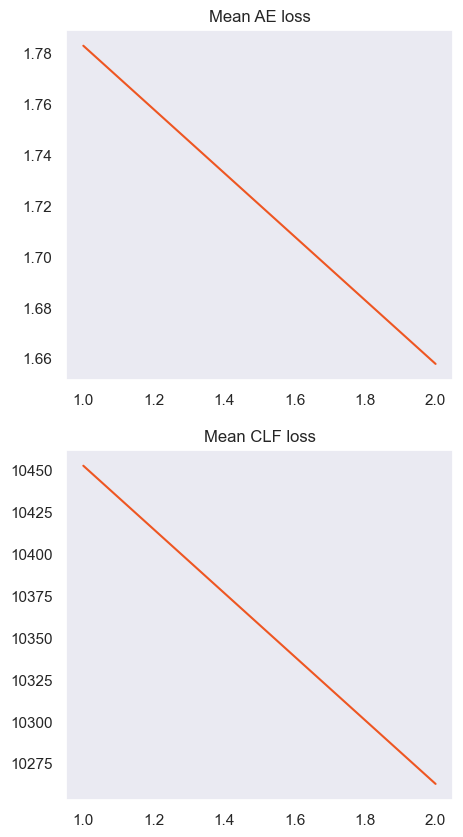

 10%|████████▎                                                                          | 2/20 [01:33<14:04, 46.90s/it]


KeyboardInterrupt: 

In [16]:
train(model, criterion, optimizer, epochs)

In [133]:
# Сохраним модель
torch.save(model, f'{m_baf_path}\VAE.pt')

In [15]:
f'{m_baf_path}\VAE.pt'

'BAF_DL_models\\VAE.pt'

In [20]:
# Загрузим модель
model = torch.load(f'{m_baf_path}\VAE.pt')
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=61, out_features=3904, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3904, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=16, bias=True)
    (7): ReLU()
  )
  (decoder_body): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=3904, bias=True)
    (5): ReLU()
  )
  (decoder_head): Linear(in_features=3904, out_features=61, bias=True)
  (classifier_head): Sequential(
    (0): Linear(in_features=3904, out_features=2, bias=True)
    (1): Softmax(dim=1)
  )
)

### Сделаем прогнозы

In [23]:
def get_prediction(model, d_loader):
    global batch_size
  
    d_predictions = []
    c_predicrions = []
    for batch in d_loader:
        x_batch = batch[0].to(DEVICE)
        dec_pred, clf = model(x_batch)
        d_predictions.append(dec_pred.detach().cpu().numpy())
        c_predicrions.append(clf.detach().cpu().numpy())
  
    dec_predictions = np.concatenate(d_predictions)
    clf_predictions = np.concatenate(c_predicrions)
    return dec_predictions, clf_predictions

In [24]:
X_train_pred, y_train_pred = get_prediction(model, train_loader)

In [30]:
X_val_pred, y_val_pred = get_prediction(model, val_loader)
X_test_pred, y_test_pred = get_prediction(model, test_loader)

In [31]:
metrics.show_metrics(y_test, y_test_pred)

True positive rate (recall):  0.20952050034746353
False positive rate:  0.18172193555728158
Precision:  0.016151064684612294
Recall:  0.20952050034746353
True negative rate:  0.8182780644427184
ROC-AUC:  0.513899282395091
F1:  0.029990301643747046
MCC:  0.008474085657690733
G-mean:  0.41406041767523777


### Оценки:
- Голова классификатора по сути не обучалась, поэтому результаты не очень

In [32]:
#Обучим модель на разности Выхода и Входа Auto Encoder-а
VAE_train = X_train_pred - X_train
VAE_val = X_val_pred - X_val
VAE_test = X_test_pred - X_test

# <span style='background-color: #D6F99B'> CatBoost Classifier на разности входа и выхода VAE </span>

In [33]:
CatBoost = CatBoostClassifier(iterations=5000,
                           eval_metric='F1',
                           learning_rate=0.009,
                           use_best_model=True,
                           random_state=42,
                           auto_class_weights='Balanced',
                           verbose=False,
                           task_type="GPU")

CatBoost.fit(VAE_train, y_train,
          verbose=True,
          eval_set = (VAE_val, y_val),
          plot=False)

with open(f'{m_baf_path}\VAECatBoost.pickle', 'wb') as f:
    pickle.dump(CatBoost, f)

0:	learn: 0.7516954	test: 0.7273670	best: 0.7273670 (0)	total: 12.9ms	remaining: 1m 4s
1:	learn: 0.7566565	test: 0.7375338	best: 0.7375338 (1)	total: 23.7ms	remaining: 59.1s
2:	learn: 0.7524339	test: 0.7356226	best: 0.7375338 (1)	total: 35.2ms	remaining: 58.6s
3:	learn: 0.7656150	test: 0.7519875	best: 0.7519875 (3)	total: 47.1ms	remaining: 58.8s
4:	learn: 0.7620380	test: 0.7472123	best: 0.7519875 (3)	total: 59.2ms	remaining: 59.1s
5:	learn: 0.7620018	test: 0.7491185	best: 0.7519875 (3)	total: 70.2ms	remaining: 58.4s
6:	learn: 0.7617265	test: 0.7481642	best: 0.7519875 (3)	total: 82.1ms	remaining: 58.6s
7:	learn: 0.7615981	test: 0.7482221	best: 0.7519875 (3)	total: 94.1ms	remaining: 58.7s
8:	learn: 0.7679638	test: 0.7522609	best: 0.7522609 (8)	total: 106ms	remaining: 58.7s
9:	learn: 0.7679551	test: 0.7522147	best: 0.7522609 (8)	total: 117ms	remaining: 58.3s
10:	learn: 0.7614846	test: 0.7466201	best: 0.7522609 (8)	total: 128ms	remaining: 58.2s
11:	learn: 0.7657156	test: 0.7502554	best: 0.

105:	learn: 0.7756156	test: 0.7650714	best: 0.7659723 (104)	total: 1.27s	remaining: 58.8s
106:	learn: 0.7759993	test: 0.7661637	best: 0.7661637 (106)	total: 1.28s	remaining: 58.8s
107:	learn: 0.7767009	test: 0.7668023	best: 0.7668023 (107)	total: 1.3s	remaining: 58.7s
108:	learn: 0.7764191	test: 0.7668288	best: 0.7668288 (108)	total: 1.31s	remaining: 58.7s
109:	learn: 0.7763461	test: 0.7677278	best: 0.7677278 (109)	total: 1.32s	remaining: 58.7s
110:	learn: 0.7761738	test: 0.7664024	best: 0.7677278 (109)	total: 1.33s	remaining: 58.7s
111:	learn: 0.7760224	test: 0.7663995	best: 0.7677278 (109)	total: 1.34s	remaining: 58.6s
112:	learn: 0.7760453	test: 0.7663111	best: 0.7677278 (109)	total: 1.35s	remaining: 58.6s
113:	learn: 0.7764266	test: 0.7658872	best: 0.7677278 (109)	total: 1.37s	remaining: 58.6s
114:	learn: 0.7765521	test: 0.7674761	best: 0.7677278 (109)	total: 1.38s	remaining: 58.5s
115:	learn: 0.7767758	test: 0.7670529	best: 0.7677278 (109)	total: 1.39s	remaining: 58.5s
116:	learn:

202:	learn: 0.7924439	test: 0.7772654	best: 0.7772982 (201)	total: 2.32s	remaining: 54.9s
203:	learn: 0.7922157	test: 0.7773698	best: 0.7773698 (203)	total: 2.33s	remaining: 54.9s
204:	learn: 0.7919863	test: 0.7782940	best: 0.7782940 (204)	total: 2.35s	remaining: 54.9s
205:	learn: 0.7921958	test: 0.7783149	best: 0.7783149 (205)	total: 2.36s	remaining: 54.9s
206:	learn: 0.7923707	test: 0.7779036	best: 0.7783149 (205)	total: 2.37s	remaining: 54.9s
207:	learn: 0.7923778	test: 0.7779454	best: 0.7783149 (205)	total: 2.38s	remaining: 54.9s
208:	learn: 0.7926364	test: 0.7770652	best: 0.7783149 (205)	total: 2.39s	remaining: 54.9s
209:	learn: 0.7930198	test: 0.7770413	best: 0.7783149 (205)	total: 2.4s	remaining: 54.8s
210:	learn: 0.7930587	test: 0.7775308	best: 0.7783149 (205)	total: 2.42s	remaining: 54.8s
211:	learn: 0.7930126	test: 0.7770473	best: 0.7783149 (205)	total: 2.42s	remaining: 54.8s
212:	learn: 0.7923962	test: 0.7770204	best: 0.7783149 (205)	total: 2.44s	remaining: 54.7s
213:	learn:

295:	learn: 0.8015087	test: 0.7780061	best: 0.7806250 (266)	total: 3.37s	remaining: 53.6s
296:	learn: 0.8015981	test: 0.7770874	best: 0.7806250 (266)	total: 3.38s	remaining: 53.6s
297:	learn: 0.8014531	test: 0.7775634	best: 0.7806250 (266)	total: 3.4s	remaining: 53.6s
298:	learn: 0.8016541	test: 0.7776083	best: 0.7806250 (266)	total: 3.41s	remaining: 53.6s
299:	learn: 0.8014952	test: 0.7785413	best: 0.7806250 (266)	total: 3.42s	remaining: 53.5s
300:	learn: 0.8016123	test: 0.7790492	best: 0.7806250 (266)	total: 3.43s	remaining: 53.5s
301:	learn: 0.8015398	test: 0.7790162	best: 0.7806250 (266)	total: 3.44s	remaining: 53.5s
302:	learn: 0.8017173	test: 0.7790432	best: 0.7806250 (266)	total: 3.45s	remaining: 53.5s
303:	learn: 0.8017216	test: 0.7790761	best: 0.7806250 (266)	total: 3.46s	remaining: 53.5s
304:	learn: 0.8017607	test: 0.7786071	best: 0.7806250 (266)	total: 3.47s	remaining: 53.5s
305:	learn: 0.8017728	test: 0.7781558	best: 0.7806250 (266)	total: 3.48s	remaining: 53.5s
306:	learn:

404:	learn: 0.8068309	test: 0.7803026	best: 0.7806250 (266)	total: 4.62s	remaining: 52.4s
405:	learn: 0.8069928	test: 0.7807930	best: 0.7807930 (405)	total: 4.63s	remaining: 52.4s
406:	learn: 0.8070985	test: 0.7803327	best: 0.7807930 (405)	total: 4.64s	remaining: 52.4s
407:	learn: 0.8069470	test: 0.7808141	best: 0.7808141 (407)	total: 4.65s	remaining: 52.4s
408:	learn: 0.8068697	test: 0.7808201	best: 0.7808201 (408)	total: 4.67s	remaining: 52.4s
409:	learn: 0.8068806	test: 0.7808472	best: 0.7808472 (409)	total: 4.68s	remaining: 52.4s
410:	learn: 0.8069803	test: 0.7808622	best: 0.7808622 (410)	total: 4.69s	remaining: 52.4s
411:	learn: 0.8068921	test: 0.7808772	best: 0.7808772 (411)	total: 4.7s	remaining: 52.4s
412:	learn: 0.8069869	test: 0.7809043	best: 0.7809043 (412)	total: 4.71s	remaining: 52.4s
413:	learn: 0.8069936	test: 0.7809284	best: 0.7809284 (413)	total: 4.73s	remaining: 52.4s
414:	learn: 0.8070957	test: 0.7814185	best: 0.7814185 (414)	total: 4.74s	remaining: 52.4s
415:	learn:

509:	learn: 0.8101714	test: 0.7804314	best: 0.7815028 (419)	total: 5.86s	remaining: 51.6s
510:	learn: 0.8100871	test: 0.7808896	best: 0.7815028 (419)	total: 5.87s	remaining: 51.6s
511:	learn: 0.8101848	test: 0.7804796	best: 0.7815028 (419)	total: 5.88s	remaining: 51.5s
512:	learn: 0.8101902	test: 0.7809650	best: 0.7815028 (419)	total: 5.89s	remaining: 51.5s
513:	learn: 0.8101963	test: 0.7809590	best: 0.7815028 (419)	total: 5.9s	remaining: 51.5s
514:	learn: 0.8102079	test: 0.7809801	best: 0.7815028 (419)	total: 5.92s	remaining: 51.5s
515:	learn: 0.8102139	test: 0.7805459	best: 0.7815028 (419)	total: 5.93s	remaining: 51.5s
516:	learn: 0.8104134	test: 0.7805188	best: 0.7815028 (419)	total: 5.94s	remaining: 51.5s
517:	learn: 0.8104031	test: 0.7805007	best: 0.7815028 (419)	total: 5.95s	remaining: 51.5s
518:	learn: 0.8103377	test: 0.7804947	best: 0.7815028 (419)	total: 5.96s	remaining: 51.5s
519:	learn: 0.8102674	test: 0.7809982	best: 0.7815028 (419)	total: 5.97s	remaining: 51.5s
520:	learn:

617:	learn: 0.8136289	test: 0.7832438	best: 0.7832438 (617)	total: 7.14s	remaining: 50.6s
618:	learn: 0.8136338	test: 0.7823166	best: 0.7832438 (617)	total: 7.15s	remaining: 50.6s
619:	learn: 0.8135572	test: 0.7827986	best: 0.7832438 (617)	total: 7.16s	remaining: 50.6s
620:	learn: 0.8136405	test: 0.7832892	best: 0.7832892 (620)	total: 7.17s	remaining: 50.6s
621:	learn: 0.8134830	test: 0.7833194	best: 0.7833194 (621)	total: 7.18s	remaining: 50.6s
622:	learn: 0.8134830	test: 0.7828923	best: 0.7833194 (621)	total: 7.2s	remaining: 50.6s
623:	learn: 0.8135730	test: 0.7829014	best: 0.7833194 (621)	total: 7.21s	remaining: 50.5s
624:	learn: 0.8134946	test: 0.7828923	best: 0.7833194 (621)	total: 7.22s	remaining: 50.5s
625:	learn: 0.8135986	test: 0.7833678	best: 0.7833678 (625)	total: 7.23s	remaining: 50.5s
626:	learn: 0.8135183	test: 0.7833648	best: 0.7833678 (625)	total: 7.24s	remaining: 50.5s
627:	learn: 0.8136960	test: 0.7834132	best: 0.7834132 (627)	total: 7.25s	remaining: 50.5s
628:	learn:

724:	learn: 0.8168379	test: 0.7822835	best: 0.7834556 (637)	total: 8.4s	remaining: 49.5s
725:	learn: 0.8168275	test: 0.7823016	best: 0.7834556 (637)	total: 8.41s	remaining: 49.5s
726:	learn: 0.8167439	test: 0.7827936	best: 0.7834556 (637)	total: 8.43s	remaining: 49.5s
727:	learn: 0.8168349	test: 0.7827905	best: 0.7834556 (637)	total: 8.44s	remaining: 49.5s
728:	learn: 0.8168416	test: 0.7827875	best: 0.7834556 (637)	total: 8.45s	remaining: 49.5s
729:	learn: 0.8168434	test: 0.7828057	best: 0.7834556 (637)	total: 8.46s	remaining: 49.5s
730:	learn: 0.8169288	test: 0.7823471	best: 0.7834556 (637)	total: 8.47s	remaining: 49.5s
731:	learn: 0.8170289	test: 0.7823955	best: 0.7834556 (637)	total: 8.48s	remaining: 49.5s
732:	learn: 0.8170356	test: 0.7819335	best: 0.7834556 (637)	total: 8.5s	remaining: 49.5s
733:	learn: 0.8169667	test: 0.7819305	best: 0.7834556 (637)	total: 8.51s	remaining: 49.5s
734:	learn: 0.8169765	test: 0.7819274	best: 0.7834556 (637)	total: 8.52s	remaining: 49.4s
735:	learn: 

836:	learn: 0.8203060	test: 0.7832234	best: 0.7835459 (763)	total: 9.67s	remaining: 48.1s
837:	learn: 0.8203097	test: 0.7832447	best: 0.7835459 (763)	total: 9.68s	remaining: 48.1s
838:	learn: 0.8204908	test: 0.7832538	best: 0.7835459 (763)	total: 9.69s	remaining: 48s
839:	learn: 0.8204883	test: 0.7832568	best: 0.7835459 (763)	total: 9.69s	remaining: 48s
840:	learn: 0.8205911	test: 0.7828311	best: 0.7835459 (763)	total: 9.7s	remaining: 48s
841:	learn: 0.8206773	test: 0.7828007	best: 0.7835459 (763)	total: 9.71s	remaining: 47.9s
842:	learn: 0.8207043	test: 0.7827977	best: 0.7835459 (763)	total: 9.71s	remaining: 47.9s
843:	learn: 0.8206224	test: 0.7828098	best: 0.7835459 (763)	total: 9.72s	remaining: 47.9s
844:	learn: 0.8207098	test: 0.7828098	best: 0.7835459 (763)	total: 9.73s	remaining: 47.8s
845:	learn: 0.8208040	test: 0.7827855	best: 0.7835459 (763)	total: 9.74s	remaining: 47.8s
846:	learn: 0.8208101	test: 0.7828311	best: 0.7835459 (763)	total: 9.75s	remaining: 47.8s
847:	learn: 0.820

929:	learn: 0.8234252	test: 0.7818824	best: 0.7835459 (763)	total: 10.7s	remaining: 47s
930:	learn: 0.8235166	test: 0.7819098	best: 0.7835459 (763)	total: 10.7s	remaining: 47s
931:	learn: 0.8235191	test: 0.7819280	best: 0.7835459 (763)	total: 10.8s	remaining: 47s
932:	learn: 0.8235271	test: 0.7819219	best: 0.7835459 (763)	total: 10.8s	remaining: 46.9s
933:	learn: 0.8235246	test: 0.7819402	best: 0.7835459 (763)	total: 10.8s	remaining: 46.9s
934:	learn: 0.8234485	test: 0.7819341	best: 0.7835459 (763)	total: 10.8s	remaining: 46.9s
935:	learn: 0.8235387	test: 0.7810123	best: 0.7835459 (763)	total: 10.8s	remaining: 46.9s
936:	learn: 0.8238111	test: 0.7814977	best: 0.7835459 (763)	total: 10.8s	remaining: 46.9s
937:	learn: 0.8238234	test: 0.7819523	best: 0.7835459 (763)	total: 10.8s	remaining: 46.9s
938:	learn: 0.8237357	test: 0.7819584	best: 0.7835459 (763)	total: 10.8s	remaining: 46.9s
939:	learn: 0.8239136	test: 0.7819736	best: 0.7835459 (763)	total: 10.8s	remaining: 46.9s
940:	learn: 0.82

1026:	learn: 0.8259139	test: 0.7816018	best: 0.7835459 (763)	total: 11.8s	remaining: 45.6s
1027:	learn: 0.8260087	test: 0.7816292	best: 0.7835459 (763)	total: 11.8s	remaining: 45.6s
1028:	learn: 0.8260272	test: 0.7816262	best: 0.7835459 (763)	total: 11.8s	remaining: 45.6s
1029:	learn: 0.8259477	test: 0.7816140	best: 0.7835459 (763)	total: 11.8s	remaining: 45.6s
1030:	learn: 0.8258676	test: 0.7816201	best: 0.7835459 (763)	total: 11.9s	remaining: 45.6s
1031:	learn: 0.8258689	test: 0.7816201	best: 0.7835459 (763)	total: 11.9s	remaining: 45.6s
1032:	learn: 0.8260555	test: 0.7816079	best: 0.7835459 (763)	total: 11.9s	remaining: 45.6s
1033:	learn: 0.8259828	test: 0.7815988	best: 0.7835459 (763)	total: 11.9s	remaining: 45.6s
1034:	learn: 0.8260697	test: 0.7816596	best: 0.7835459 (763)	total: 11.9s	remaining: 45.6s
1035:	learn: 0.8261670	test: 0.7816718	best: 0.7835459 (763)	total: 11.9s	remaining: 45.6s
1036:	learn: 0.8262637	test: 0.7816687	best: 0.7835459 (763)	total: 11.9s	remaining: 45.6s

1133:	learn: 0.8283944	test: 0.7824512	best: 0.7835459 (763)	total: 13s	remaining: 44.5s
1134:	learn: 0.8285732	test: 0.7819804	best: 0.7835459 (763)	total: 13.1s	remaining: 44.4s
1135:	learn: 0.8284921	test: 0.7819895	best: 0.7835459 (763)	total: 13.1s	remaining: 44.4s
1136:	learn: 0.8286672	test: 0.7819986	best: 0.7835459 (763)	total: 13.1s	remaining: 44.4s
1137:	learn: 0.8286728	test: 0.7820078	best: 0.7835459 (763)	total: 13.1s	remaining: 44.4s
1138:	learn: 0.8285942	test: 0.7820352	best: 0.7835459 (763)	total: 13.1s	remaining: 44.4s
1139:	learn: 0.8286937	test: 0.7820322	best: 0.7835459 (763)	total: 13.1s	remaining: 44.4s
1140:	learn: 0.8287129	test: 0.7815731	best: 0.7835459 (763)	total: 13.1s	remaining: 44.4s
1141:	learn: 0.8288891	test: 0.7815792	best: 0.7835459 (763)	total: 13.1s	remaining: 44.4s
1142:	learn: 0.8288112	test: 0.7815823	best: 0.7835459 (763)	total: 13.1s	remaining: 44.4s
1143:	learn: 0.8288050	test: 0.7815914	best: 0.7835459 (763)	total: 13.2s	remaining: 44.4s
1

1240:	learn: 0.8317215	test: 0.7825292	best: 0.7835459 (763)	total: 14.3s	remaining: 43.3s
1241:	learn: 0.8317215	test: 0.7825353	best: 0.7835459 (763)	total: 14.3s	remaining: 43.3s
1242:	learn: 0.8317289	test: 0.7825567	best: 0.7835459 (763)	total: 14.3s	remaining: 43.3s
1243:	learn: 0.8316414	test: 0.7825597	best: 0.7835459 (763)	total: 14.3s	remaining: 43.3s
1244:	learn: 0.8316643	test: 0.7825872	best: 0.7835459 (763)	total: 14.4s	remaining: 43.3s
1245:	learn: 0.8316680	test: 0.7825903	best: 0.7835459 (763)	total: 14.4s	remaining: 43.3s
1246:	learn: 0.8318399	test: 0.7825872	best: 0.7835459 (763)	total: 14.4s	remaining: 43.3s
1247:	learn: 0.8318461	test: 0.7826025	best: 0.7835459 (763)	total: 14.4s	remaining: 43.3s
1248:	learn: 0.8317642	test: 0.7826116	best: 0.7835459 (763)	total: 14.4s	remaining: 43.3s
1249:	learn: 0.8319429	test: 0.7826116	best: 0.7835459 (763)	total: 14.4s	remaining: 43.3s
1250:	learn: 0.8318609	test: 0.7821769	best: 0.7835459 (763)	total: 14.4s	remaining: 43.3s

1339:	learn: 0.8342408	test: 0.7799235	best: 0.7835459 (763)	total: 15.4s	remaining: 41.9s
1340:	learn: 0.8344202	test: 0.7799174	best: 0.7835459 (763)	total: 15.4s	remaining: 41.9s
1341:	learn: 0.8345155	test: 0.7799448	best: 0.7835459 (763)	total: 15.4s	remaining: 41.9s
1342:	learn: 0.8345186	test: 0.7799357	best: 0.7835459 (763)	total: 15.4s	remaining: 41.9s
1343:	learn: 0.8345261	test: 0.7799296	best: 0.7835459 (763)	total: 15.4s	remaining: 41.9s
1344:	learn: 0.8345360	test: 0.7799662	best: 0.7835459 (763)	total: 15.4s	remaining: 41.9s
1345:	learn: 0.8345409	test: 0.7799906	best: 0.7835459 (763)	total: 15.4s	remaining: 41.9s
1346:	learn: 0.8346331	test: 0.7799754	best: 0.7835459 (763)	total: 15.4s	remaining: 41.9s
1347:	learn: 0.8345614	test: 0.7799937	best: 0.7835459 (763)	total: 15.4s	remaining: 41.8s
1348:	learn: 0.8344810	test: 0.7799937	best: 0.7835459 (763)	total: 15.5s	remaining: 41.8s
1349:	learn: 0.8345751	test: 0.7804857	best: 0.7835459 (763)	total: 15.5s	remaining: 41.8s

1437:	learn: 0.8375182	test: 0.7814205	best: 0.7835459 (763)	total: 16.4s	remaining: 40.7s
1438:	learn: 0.8374419	test: 0.7814236	best: 0.7835459 (763)	total: 16.4s	remaining: 40.6s
1439:	learn: 0.8374407	test: 0.7814114	best: 0.7835459 (763)	total: 16.4s	remaining: 40.6s
1440:	learn: 0.8374500	test: 0.7814144	best: 0.7835459 (763)	total: 16.4s	remaining: 40.6s
1441:	learn: 0.8376225	test: 0.7814236	best: 0.7835459 (763)	total: 16.5s	remaining: 40.6s
1442:	learn: 0.8375325	test: 0.7814542	best: 0.7835459 (763)	total: 16.5s	remaining: 40.6s
1443:	learn: 0.8376256	test: 0.7814542	best: 0.7835459 (763)	total: 16.5s	remaining: 40.6s
1444:	learn: 0.8376256	test: 0.7814725	best: 0.7835459 (763)	total: 16.5s	remaining: 40.6s
1445:	learn: 0.8377193	test: 0.7814664	best: 0.7835459 (763)	total: 16.5s	remaining: 40.6s
1446:	learn: 0.8379599	test: 0.7814756	best: 0.7835459 (763)	total: 16.5s	remaining: 40.5s
1447:	learn: 0.8380492	test: 0.7814603	best: 0.7835459 (763)	total: 16.5s	remaining: 40.5s

1529:	learn: 0.8398546	test: 0.7804207	best: 0.7835459 (763)	total: 17.5s	remaining: 39.6s
1530:	learn: 0.8399387	test: 0.7804238	best: 0.7835459 (763)	total: 17.5s	remaining: 39.6s
1531:	learn: 0.8399430	test: 0.7804360	best: 0.7835459 (763)	total: 17.5s	remaining: 39.6s
1532:	learn: 0.8400359	test: 0.7804483	best: 0.7835459 (763)	total: 17.5s	remaining: 39.6s
1533:	learn: 0.8401262	test: 0.7804391	best: 0.7835459 (763)	total: 17.5s	remaining: 39.6s
1534:	learn: 0.8402047	test: 0.7804544	best: 0.7835459 (763)	total: 17.5s	remaining: 39.6s
1535:	learn: 0.8400545	test: 0.7804299	best: 0.7835459 (763)	total: 17.5s	remaining: 39.6s
1536:	learn: 0.8401492	test: 0.7804483	best: 0.7835459 (763)	total: 17.6s	remaining: 39.5s
1537:	learn: 0.8401555	test: 0.7804544	best: 0.7835459 (763)	total: 17.6s	remaining: 39.5s
1538:	learn: 0.8401642	test: 0.7804728	best: 0.7835459 (763)	total: 17.6s	remaining: 39.5s
1539:	learn: 0.8400882	test: 0.7804789	best: 0.7835459 (763)	total: 17.6s	remaining: 39.5s

1638:	learn: 0.8421102	test: 0.7795577	best: 0.7835459 (763)	total: 18.7s	remaining: 38.4s
1639:	learn: 0.8420325	test: 0.7795638	best: 0.7835459 (763)	total: 18.8s	remaining: 38.4s
1640:	learn: 0.8420375	test: 0.7796006	best: 0.7835459 (763)	total: 18.8s	remaining: 38.4s
1641:	learn: 0.8420406	test: 0.7795976	best: 0.7835459 (763)	total: 18.8s	remaining: 38.4s
1642:	learn: 0.8421426	test: 0.7796221	best: 0.7835459 (763)	total: 18.8s	remaining: 38.4s
1643:	learn: 0.8421464	test: 0.7791549	best: 0.7835459 (763)	total: 18.8s	remaining: 38.4s
1644:	learn: 0.8424192	test: 0.7791672	best: 0.7835459 (763)	total: 18.8s	remaining: 38.4s
1645:	learn: 0.8424167	test: 0.7786781	best: 0.7835459 (763)	total: 18.8s	remaining: 38.4s
1646:	learn: 0.8424956	test: 0.7786812	best: 0.7835459 (763)	total: 18.9s	remaining: 38.4s
1647:	learn: 0.8425994	test: 0.7786873	best: 0.7835459 (763)	total: 18.9s	remaining: 38.4s
1648:	learn: 0.8424361	test: 0.7786690	best: 0.7835459 (763)	total: 18.9s	remaining: 38.4s

1744:	learn: 0.8456078	test: 0.7788571	best: 0.7835459 (763)	total: 20s	remaining: 37.3s
1745:	learn: 0.8455243	test: 0.7788632	best: 0.7835459 (763)	total: 20s	remaining: 37.3s
1746:	learn: 0.8454427	test: 0.7788663	best: 0.7835459 (763)	total: 20s	remaining: 37.3s
1747:	learn: 0.8455306	test: 0.7788694	best: 0.7835459 (763)	total: 20s	remaining: 37.3s
1748:	learn: 0.8455387	test: 0.7788602	best: 0.7835459 (763)	total: 20s	remaining: 37.3s
1749:	learn: 0.8457126	test: 0.7788847	best: 0.7835459 (763)	total: 20.1s	remaining: 37.2s
1750:	learn: 0.8456347	test: 0.7788786	best: 0.7835459 (763)	total: 20.1s	remaining: 37.2s
1751:	learn: 0.8456303	test: 0.7783887	best: 0.7835459 (763)	total: 20.1s	remaining: 37.2s
1752:	learn: 0.8458035	test: 0.7783948	best: 0.7835459 (763)	total: 20.1s	remaining: 37.2s
1753:	learn: 0.8458192	test: 0.7784163	best: 0.7835459 (763)	total: 20.1s	remaining: 37.2s
1754:	learn: 0.8458279	test: 0.7784101	best: 0.7835459 (763)	total: 20.1s	remaining: 37.2s
1755:	lea

1845:	learn: 0.8476789	test: 0.7782881	best: 0.7835459 (763)	total: 21.1s	remaining: 36s
1846:	learn: 0.8478504	test: 0.7782727	best: 0.7835459 (763)	total: 21.1s	remaining: 36s
1847:	learn: 0.8478567	test: 0.7782758	best: 0.7835459 (763)	total: 21.1s	remaining: 35.9s
1848:	learn: 0.8477791	test: 0.7782666	best: 0.7835459 (763)	total: 21.1s	remaining: 35.9s
1849:	learn: 0.8477904	test: 0.7782758	best: 0.7835459 (763)	total: 21.1s	remaining: 35.9s
1850:	learn: 0.8479588	test: 0.7778096	best: 0.7835459 (763)	total: 21.1s	remaining: 35.9s
1851:	learn: 0.8479675	test: 0.7778065	best: 0.7835459 (763)	total: 21.1s	remaining: 35.9s
1852:	learn: 0.8478893	test: 0.7773215	best: 0.7835459 (763)	total: 21.1s	remaining: 35.9s
1853:	learn: 0.8478029	test: 0.7773185	best: 0.7835459 (763)	total: 21.1s	remaining: 35.9s
1854:	learn: 0.8478148	test: 0.7777973	best: 0.7835459 (763)	total: 21.2s	remaining: 35.9s
1855:	learn: 0.8478161	test: 0.7778188	best: 0.7835459 (763)	total: 21.2s	remaining: 35.9s
185

1952:	learn: 0.8498244	test: 0.7764504	best: 0.7835459 (763)	total: 22.3s	remaining: 34.8s
1953:	learn: 0.8499138	test: 0.7764597	best: 0.7835459 (763)	total: 22.3s	remaining: 34.8s
1954:	learn: 0.8499163	test: 0.7764504	best: 0.7835459 (763)	total: 22.3s	remaining: 34.8s
1955:	learn: 0.8499269	test: 0.7764535	best: 0.7835459 (763)	total: 22.4s	remaining: 34.8s
1956:	learn: 0.8498458	test: 0.7764842	best: 0.7835459 (763)	total: 22.4s	remaining: 34.8s
1957:	learn: 0.8499307	test: 0.7764812	best: 0.7835459 (763)	total: 22.4s	remaining: 34.8s
1958:	learn: 0.8501050	test: 0.7765057	best: 0.7835459 (763)	total: 22.4s	remaining: 34.8s
1959:	learn: 0.8501144	test: 0.7765272	best: 0.7835459 (763)	total: 22.4s	remaining: 34.7s
1960:	learn: 0.8502948	test: 0.7765395	best: 0.7835459 (763)	total: 22.4s	remaining: 34.7s
1961:	learn: 0.8503967	test: 0.7765579	best: 0.7835459 (763)	total: 22.4s	remaining: 34.7s
1962:	learn: 0.8502294	test: 0.7765764	best: 0.7835459 (763)	total: 22.4s	remaining: 34.7s

2057:	learn: 0.8528643	test: 0.7756344	best: 0.7835459 (763)	total: 23.6s	remaining: 33.7s
2058:	learn: 0.8528693	test: 0.7756191	best: 0.7835459 (763)	total: 23.6s	remaining: 33.7s
2059:	learn: 0.8530467	test: 0.7756498	best: 0.7835459 (763)	total: 23.6s	remaining: 33.7s
2060:	learn: 0.8529722	test: 0.7756559	best: 0.7835459 (763)	total: 23.6s	remaining: 33.7s
2061:	learn: 0.8529753	test: 0.7756436	best: 0.7835459 (763)	total: 23.6s	remaining: 33.6s
2062:	learn: 0.8528970	test: 0.7756436	best: 0.7835459 (763)	total: 23.6s	remaining: 33.6s
2063:	learn: 0.8528920	test: 0.7756467	best: 0.7835459 (763)	total: 23.6s	remaining: 33.6s
2064:	learn: 0.8528995	test: 0.7756498	best: 0.7835459 (763)	total: 23.6s	remaining: 33.6s
2065:	learn: 0.8529033	test: 0.7756406	best: 0.7835459 (763)	total: 23.7s	remaining: 33.6s
2066:	learn: 0.8529209	test: 0.7756252	best: 0.7835459 (763)	total: 23.7s	remaining: 33.6s
2067:	learn: 0.8529209	test: 0.7756283	best: 0.7835459 (763)	total: 23.7s	remaining: 33.6s

2151:	learn: 0.8550244	test: 0.7750579	best: 0.7835459 (763)	total: 24.6s	remaining: 32.6s
2152:	learn: 0.8552907	test: 0.7750579	best: 0.7835459 (763)	total: 24.6s	remaining: 32.6s
2153:	learn: 0.8553751	test: 0.7750640	best: 0.7835459 (763)	total: 24.6s	remaining: 32.6s
2154:	learn: 0.8553776	test: 0.7750732	best: 0.7835459 (763)	total: 24.7s	remaining: 32.6s
2155:	learn: 0.8554682	test: 0.7750794	best: 0.7835459 (763)	total: 24.7s	remaining: 32.5s
2156:	learn: 0.8553896	test: 0.7755555	best: 0.7835459 (763)	total: 24.7s	remaining: 32.5s
2157:	learn: 0.8553883	test: 0.7760342	best: 0.7835459 (763)	total: 24.7s	remaining: 32.5s
2158:	learn: 0.8553090	test: 0.7760404	best: 0.7835459 (763)	total: 24.7s	remaining: 32.5s
2159:	learn: 0.8553153	test: 0.7755339	best: 0.7835459 (763)	total: 24.7s	remaining: 32.5s
2160:	learn: 0.8553159	test: 0.7750702	best: 0.7835459 (763)	total: 24.7s	remaining: 32.5s
2161:	learn: 0.8554091	test: 0.7745906	best: 0.7835459 (763)	total: 24.8s	remaining: 32.5s

2258:	learn: 0.8570824	test: 0.7736694	best: 0.7835459 (763)	total: 25.9s	remaining: 31.4s
2259:	learn: 0.8570925	test: 0.7736786	best: 0.7835459 (763)	total: 25.9s	remaining: 31.4s
2260:	learn: 0.8571039	test: 0.7736755	best: 0.7835459 (763)	total: 25.9s	remaining: 31.4s
2261:	learn: 0.8571077	test: 0.7736663	best: 0.7835459 (763)	total: 25.9s	remaining: 31.4s
2262:	learn: 0.8571146	test: 0.7736817	best: 0.7835459 (763)	total: 25.9s	remaining: 31.4s
2263:	learn: 0.8570210	test: 0.7736848	best: 0.7835459 (763)	total: 26s	remaining: 31.4s
2264:	learn: 0.8570260	test: 0.7731913	best: 0.7835459 (763)	total: 26s	remaining: 31.4s
2265:	learn: 0.8570374	test: 0.7732036	best: 0.7835459 (763)	total: 26s	remaining: 31.4s
2266:	learn: 0.8570349	test: 0.7732005	best: 0.7835459 (763)	total: 26s	remaining: 31.3s
2267:	learn: 0.8571279	test: 0.7732036	best: 0.7835459 (763)	total: 26s	remaining: 31.3s
2268:	learn: 0.8571380	test: 0.7732036	best: 0.7835459 (763)	total: 26s	remaining: 31.3s
2269:	learn

2350:	learn: 0.8590991	test: 0.7726677	best: 0.7835459 (763)	total: 27s	remaining: 30.4s
2351:	learn: 0.8590177	test: 0.7726431	best: 0.7835459 (763)	total: 27s	remaining: 30.4s
2352:	learn: 0.8590190	test: 0.7726554	best: 0.7835459 (763)	total: 27s	remaining: 30.4s
2353:	learn: 0.8589413	test: 0.7726523	best: 0.7835459 (763)	total: 27s	remaining: 30.3s
2354:	learn: 0.8589464	test: 0.7726554	best: 0.7835459 (763)	total: 27s	remaining: 30.3s
2355:	learn: 0.8588662	test: 0.7726708	best: 0.7835459 (763)	total: 27s	remaining: 30.3s
2356:	learn: 0.8588712	test: 0.7726708	best: 0.7835459 (763)	total: 27s	remaining: 30.3s
2357:	learn: 0.8588744	test: 0.7726647	best: 0.7835459 (763)	total: 27s	remaining: 30.3s
2358:	learn: 0.8589660	test: 0.7726585	best: 0.7835459 (763)	total: 27.1s	remaining: 30.3s
2359:	learn: 0.8590461	test: 0.7726708	best: 0.7835459 (763)	total: 27.1s	remaining: 30.3s
2360:	learn: 0.8591345	test: 0.7726739	best: 0.7835459 (763)	total: 27.1s	remaining: 30.3s
2361:	learn: 0.

2446:	learn: 0.8605048	test: 0.7716194	best: 0.7835459 (763)	total: 28s	remaining: 29.2s
2447:	learn: 0.8606782	test: 0.7716287	best: 0.7835459 (763)	total: 28s	remaining: 29.2s
2448:	learn: 0.8606864	test: 0.7716471	best: 0.7835459 (763)	total: 28s	remaining: 29.2s
2449:	learn: 0.8606026	test: 0.7716595	best: 0.7835459 (763)	total: 28s	remaining: 29.2s
2450:	learn: 0.8606870	test: 0.7716502	best: 0.7835459 (763)	total: 28.1s	remaining: 29.2s
2451:	learn: 0.8606896	test: 0.7716564	best: 0.7835459 (763)	total: 28.1s	remaining: 29.2s
2452:	learn: 0.8607079	test: 0.7716687	best: 0.7835459 (763)	total: 28.1s	remaining: 29.2s
2453:	learn: 0.8607187	test: 0.7716779	best: 0.7835459 (763)	total: 28.1s	remaining: 29.1s
2454:	learn: 0.8607187	test: 0.7716841	best: 0.7835459 (763)	total: 28.1s	remaining: 29.1s
2455:	learn: 0.8607200	test: 0.7716903	best: 0.7835459 (763)	total: 28.1s	remaining: 29.1s
2456:	learn: 0.8606355	test: 0.7716872	best: 0.7835459 (763)	total: 28.1s	remaining: 29.1s
2457:	l

2555:	learn: 0.8628541	test: 0.7712092	best: 0.7835459 (763)	total: 29s	remaining: 27.8s
2556:	learn: 0.8630270	test: 0.7712216	best: 0.7835459 (763)	total: 29s	remaining: 27.8s
2557:	learn: 0.8631169	test: 0.7712308	best: 0.7835459 (763)	total: 29.1s	remaining: 27.7s
2558:	learn: 0.8632011	test: 0.7712277	best: 0.7835459 (763)	total: 29.1s	remaining: 27.7s
2559:	learn: 0.8631283	test: 0.7707400	best: 0.7835459 (763)	total: 29.1s	remaining: 27.7s
2560:	learn: 0.8631271	test: 0.7702489	best: 0.7835459 (763)	total: 29.1s	remaining: 27.7s
2561:	learn: 0.8631334	test: 0.7707339	best: 0.7835459 (763)	total: 29.1s	remaining: 27.7s
2562:	learn: 0.8631359	test: 0.7707431	best: 0.7835459 (763)	total: 29.1s	remaining: 27.7s
2563:	learn: 0.8631429	test: 0.7707493	best: 0.7835459 (763)	total: 29.1s	remaining: 27.6s
2564:	learn: 0.8631455	test: 0.7707524	best: 0.7835459 (763)	total: 29.1s	remaining: 27.6s
2565:	learn: 0.8631480	test: 0.7707585	best: 0.7835459 (763)	total: 29.1s	remaining: 27.6s
256

2662:	learn: 0.8650289	test: 0.7701396	best: 0.7835459 (763)	total: 30.1s	remaining: 26.4s
2663:	learn: 0.8650314	test: 0.7701396	best: 0.7835459 (763)	total: 30.1s	remaining: 26.4s
2664:	learn: 0.8650397	test: 0.7701519	best: 0.7835459 (763)	total: 30.1s	remaining: 26.4s
2665:	learn: 0.8649678	test: 0.7701642	best: 0.7835459 (763)	total: 30.1s	remaining: 26.4s
2666:	learn: 0.8649703	test: 0.7706435	best: 0.7835459 (763)	total: 30.1s	remaining: 26.4s
2667:	learn: 0.8649652	test: 0.7701426	best: 0.7835459 (763)	total: 30.1s	remaining: 26.3s
2668:	learn: 0.8649741	test: 0.7706373	best: 0.7835459 (763)	total: 30.1s	remaining: 26.3s
2669:	learn: 0.8649862	test: 0.7706435	best: 0.7835459 (763)	total: 30.2s	remaining: 26.3s
2670:	learn: 0.8649875	test: 0.7706219	best: 0.7835459 (763)	total: 30.2s	remaining: 26.3s
2671:	learn: 0.8650835	test: 0.7706188	best: 0.7835459 (763)	total: 30.2s	remaining: 26.3s
2672:	learn: 0.8650886	test: 0.7711255	best: 0.7835459 (763)	total: 30.2s	remaining: 26.3s

2771:	learn: 0.8667945	test: 0.7697690	best: 0.7835459 (763)	total: 31.3s	remaining: 25.2s
2772:	learn: 0.8667900	test: 0.7697813	best: 0.7835459 (763)	total: 31.4s	remaining: 25.2s
2773:	learn: 0.8667932	test: 0.7702739	best: 0.7835459 (763)	total: 31.4s	remaining: 25.2s
2774:	learn: 0.8667951	test: 0.7702677	best: 0.7835459 (763)	total: 31.4s	remaining: 25.2s
2775:	learn: 0.8668815	test: 0.7702584	best: 0.7835459 (763)	total: 31.4s	remaining: 25.1s
2776:	learn: 0.8668770	test: 0.7702831	best: 0.7835459 (763)	total: 31.4s	remaining: 25.1s
2777:	learn: 0.8668821	test: 0.7702831	best: 0.7835459 (763)	total: 31.4s	remaining: 25.1s
2778:	learn: 0.8668802	test: 0.7702862	best: 0.7835459 (763)	total: 31.4s	remaining: 25.1s
2779:	learn: 0.8669698	test: 0.7703140	best: 0.7835459 (763)	total: 31.4s	remaining: 25.1s
2780:	learn: 0.8669691	test: 0.7703202	best: 0.7835459 (763)	total: 31.4s	remaining: 25.1s
2781:	learn: 0.8668974	test: 0.7703326	best: 0.7835459 (763)	total: 31.4s	remaining: 25.1s

2867:	learn: 0.8686537	test: 0.7686563	best: 0.7835459 (763)	total: 32.4s	remaining: 24.1s
2868:	learn: 0.8686537	test: 0.7686439	best: 0.7835459 (763)	total: 32.4s	remaining: 24.1s
2869:	learn: 0.8687482	test: 0.7681559	best: 0.7835459 (763)	total: 32.4s	remaining: 24.1s
2870:	learn: 0.8686665	test: 0.7686532	best: 0.7835459 (763)	total: 32.4s	remaining: 24s
2871:	learn: 0.8686665	test: 0.7681744	best: 0.7835459 (763)	total: 32.4s	remaining: 24s
2872:	learn: 0.8686735	test: 0.7681713	best: 0.7835459 (763)	total: 32.5s	remaining: 24s
2873:	learn: 0.8686722	test: 0.7681682	best: 0.7835459 (763)	total: 32.5s	remaining: 24s
2874:	learn: 0.8686824	test: 0.7681899	best: 0.7835459 (763)	total: 32.5s	remaining: 24s
2875:	learn: 0.8687699	test: 0.7681929	best: 0.7835459 (763)	total: 32.5s	remaining: 24s
2876:	learn: 0.8688605	test: 0.7686871	best: 0.7835459 (763)	total: 32.5s	remaining: 24s
2877:	learn: 0.8688625	test: 0.7686810	best: 0.7835459 (763)	total: 32.5s	remaining: 24s
2878:	learn: 0.

2963:	learn: 0.8696293	test: 0.7666412	best: 0.7835459 (763)	total: 33.5s	remaining: 23s
2964:	learn: 0.8696242	test: 0.7666504	best: 0.7835459 (763)	total: 33.5s	remaining: 23s
2965:	learn: 0.8696369	test: 0.7666689	best: 0.7835459 (763)	total: 33.5s	remaining: 23s
2966:	learn: 0.8696420	test: 0.7666597	best: 0.7835459 (763)	total: 33.5s	remaining: 22.9s
2967:	learn: 0.8697269	test: 0.7666597	best: 0.7835459 (763)	total: 33.5s	remaining: 22.9s
2968:	learn: 0.8697326	test: 0.7666597	best: 0.7835459 (763)	total: 33.5s	remaining: 22.9s
2969:	learn: 0.8697371	test: 0.7666628	best: 0.7835459 (763)	total: 33.5s	remaining: 22.9s
2970:	learn: 0.8697435	test: 0.7666566	best: 0.7835459 (763)	total: 33.5s	remaining: 22.9s
2971:	learn: 0.8697486	test: 0.7666566	best: 0.7835459 (763)	total: 33.6s	remaining: 22.9s
2972:	learn: 0.8697518	test: 0.7666720	best: 0.7835459 (763)	total: 33.6s	remaining: 22.9s
2973:	learn: 0.8698283	test: 0.7666659	best: 0.7835459 (763)	total: 33.6s	remaining: 22.9s
2974:

3070:	learn: 0.8714525	test: 0.7660682	best: 0.7835459 (763)	total: 34.7s	remaining: 21.8s
3071:	learn: 0.8714519	test: 0.7660620	best: 0.7835459 (763)	total: 34.7s	remaining: 21.8s
3072:	learn: 0.8714672	test: 0.7660682	best: 0.7835459 (763)	total: 34.7s	remaining: 21.8s
3073:	learn: 0.8714691	test: 0.7660774	best: 0.7835459 (763)	total: 34.7s	remaining: 21.8s
3074:	learn: 0.8713972	test: 0.7660836	best: 0.7835459 (763)	total: 34.7s	remaining: 21.7s
3075:	learn: 0.8715660	test: 0.7660991	best: 0.7835459 (763)	total: 34.8s	remaining: 21.7s
3076:	learn: 0.8715634	test: 0.7660898	best: 0.7835459 (763)	total: 34.8s	remaining: 21.7s
3077:	learn: 0.8715621	test: 0.7660960	best: 0.7835459 (763)	total: 34.8s	remaining: 21.7s
3078:	learn: 0.8716468	test: 0.7660960	best: 0.7835459 (763)	total: 34.8s	remaining: 21.7s
3079:	learn: 0.8716462	test: 0.7661083	best: 0.7835459 (763)	total: 34.8s	remaining: 21.7s
3080:	learn: 0.8716532	test: 0.7661052	best: 0.7835459 (763)	total: 34.8s	remaining: 21.7s

3176:	learn: 0.8731040	test: 0.7660160	best: 0.7835459 (763)	total: 35.9s	remaining: 20.6s
3177:	learn: 0.8731040	test: 0.7660129	best: 0.7835459 (763)	total: 36s	remaining: 20.6s
3178:	learn: 0.8731891	test: 0.7660222	best: 0.7835459 (763)	total: 36s	remaining: 20.6s
3179:	learn: 0.8732775	test: 0.7660222	best: 0.7835459 (763)	total: 36s	remaining: 20.6s
3180:	learn: 0.8732788	test: 0.7660284	best: 0.7835459 (763)	total: 36s	remaining: 20.6s
3181:	learn: 0.8732026	test: 0.7660253	best: 0.7835459 (763)	total: 36s	remaining: 20.6s
3182:	learn: 0.8732096	test: 0.7650481	best: 0.7835459 (763)	total: 36s	remaining: 20.6s
3183:	learn: 0.8732166	test: 0.7650543	best: 0.7835459 (763)	total: 36s	remaining: 20.5s
3184:	learn: 0.8732173	test: 0.7655554	best: 0.7835459 (763)	total: 36s	remaining: 20.5s
3185:	learn: 0.8733056	test: 0.7650543	best: 0.7835459 (763)	total: 36s	remaining: 20.5s
3186:	learn: 0.8733076	test: 0.7650574	best: 0.7835459 (763)	total: 36.1s	remaining: 20.5s
3187:	learn: 0.87

3268:	learn: 0.8753178	test: 0.7642702	best: 0.7835459 (763)	total: 37s	remaining: 19.6s
3269:	learn: 0.8753190	test: 0.7642702	best: 0.7835459 (763)	total: 37s	remaining: 19.6s
3270:	learn: 0.8751613	test: 0.7642733	best: 0.7835459 (763)	total: 37s	remaining: 19.6s
3271:	learn: 0.8751677	test: 0.7642764	best: 0.7835459 (763)	total: 37s	remaining: 19.6s
3272:	learn: 0.8751722	test: 0.7648433	best: 0.7835459 (763)	total: 37.1s	remaining: 19.6s
3273:	learn: 0.8752514	test: 0.7648464	best: 0.7835459 (763)	total: 37.1s	remaining: 19.5s
3274:	learn: 0.8752482	test: 0.7648464	best: 0.7835459 (763)	total: 37.1s	remaining: 19.5s
3275:	learn: 0.8752552	test: 0.7648464	best: 0.7835459 (763)	total: 37.1s	remaining: 19.5s
3276:	learn: 0.8752841	test: 0.7648650	best: 0.7835459 (763)	total: 37.1s	remaining: 19.5s
3277:	learn: 0.8752982	test: 0.7648680	best: 0.7835459 (763)	total: 37.1s	remaining: 19.5s
3278:	learn: 0.8752975	test: 0.7648650	best: 0.7835459 (763)	total: 37.1s	remaining: 19.5s
3279:	l

3375:	learn: 0.8774477	test: 0.7627897	best: 0.7835459 (763)	total: 38.3s	remaining: 18.4s
3376:	learn: 0.8774502	test: 0.7627927	best: 0.7835459 (763)	total: 38.3s	remaining: 18.4s
3377:	learn: 0.8774567	test: 0.7627927	best: 0.7835459 (763)	total: 38.3s	remaining: 18.4s
3378:	learn: 0.8774631	test: 0.7627958	best: 0.7835459 (763)	total: 38.3s	remaining: 18.4s
3379:	learn: 0.8773848	test: 0.7628175	best: 0.7835459 (763)	total: 38.3s	remaining: 18.4s
3380:	learn: 0.8773918	test: 0.7628113	best: 0.7835459 (763)	total: 38.4s	remaining: 18.4s
3381:	learn: 0.8774708	test: 0.7628113	best: 0.7835459 (763)	total: 38.4s	remaining: 18.4s
3382:	learn: 0.8774759	test: 0.7628051	best: 0.7835459 (763)	total: 38.4s	remaining: 18.3s
3383:	learn: 0.8774900	test: 0.7628082	best: 0.7835459 (763)	total: 38.4s	remaining: 18.3s
3384:	learn: 0.8774958	test: 0.7628082	best: 0.7835459 (763)	total: 38.4s	remaining: 18.3s
3385:	learn: 0.8775016	test: 0.7628206	best: 0.7835459 (763)	total: 38.4s	remaining: 18.3s

3480:	learn: 0.8792065	test: 0.7622201	best: 0.7835459 (763)	total: 39.6s	remaining: 17.3s
3481:	learn: 0.8791233	test: 0.7622417	best: 0.7835459 (763)	total: 39.6s	remaining: 17.2s
3482:	learn: 0.8791233	test: 0.7617553	best: 0.7835459 (763)	total: 39.6s	remaining: 17.2s
3483:	learn: 0.8791220	test: 0.7617491	best: 0.7835459 (763)	total: 39.6s	remaining: 17.2s
3484:	learn: 0.8791310	test: 0.7617676	best: 0.7835459 (763)	total: 39.6s	remaining: 17.2s
3485:	learn: 0.8791342	test: 0.7612653	best: 0.7835459 (763)	total: 39.6s	remaining: 17.2s
3486:	learn: 0.8791348	test: 0.7612684	best: 0.7835459 (763)	total: 39.6s	remaining: 17.2s
3487:	learn: 0.8791329	test: 0.7616872	best: 0.7835459 (763)	total: 39.6s	remaining: 17.2s
3488:	learn: 0.8792207	test: 0.7616965	best: 0.7835459 (763)	total: 39.6s	remaining: 17.2s
3489:	learn: 0.8791426	test: 0.7616934	best: 0.7835459 (763)	total: 39.7s	remaining: 17.2s
3490:	learn: 0.8791483	test: 0.7617305	best: 0.7835459 (763)	total: 39.7s	remaining: 17.1s

3580:	learn: 0.8804948	test: 0.7605407	best: 0.7835459 (763)	total: 40.8s	remaining: 16.2s
3581:	learn: 0.8805012	test: 0.7605469	best: 0.7835459 (763)	total: 40.8s	remaining: 16.2s
3582:	learn: 0.8805135	test: 0.7605376	best: 0.7835459 (763)	total: 40.8s	remaining: 16.1s
3583:	learn: 0.8805147	test: 0.7605345	best: 0.7835459 (763)	total: 40.8s	remaining: 16.1s
3584:	learn: 0.8805270	test: 0.7605284	best: 0.7835459 (763)	total: 40.8s	remaining: 16.1s
3585:	learn: 0.8805263	test: 0.7605284	best: 0.7835459 (763)	total: 40.9s	remaining: 16.1s
3586:	learn: 0.8806198	test: 0.7605315	best: 0.7835459 (763)	total: 40.9s	remaining: 16.1s
3587:	learn: 0.8807106	test: 0.7605500	best: 0.7835459 (763)	total: 40.9s	remaining: 16.1s
3588:	learn: 0.8807074	test: 0.7605500	best: 0.7835459 (763)	total: 40.9s	remaining: 16.1s
3589:	learn: 0.8807963	test: 0.7605531	best: 0.7835459 (763)	total: 40.9s	remaining: 16.1s
3590:	learn: 0.8807241	test: 0.7605531	best: 0.7835459 (763)	total: 40.9s	remaining: 16.1s

3688:	learn: 0.8821908	test: 0.7598269	best: 0.7835459 (763)	total: 42.1s	remaining: 15s
3689:	learn: 0.8822770	test: 0.7598331	best: 0.7835459 (763)	total: 42.1s	remaining: 14.9s
3690:	learn: 0.8822802	test: 0.7598362	best: 0.7835459 (763)	total: 42.1s	remaining: 14.9s
3691:	learn: 0.8822024	test: 0.7598207	best: 0.7835459 (763)	total: 42.1s	remaining: 14.9s
3692:	learn: 0.8822018	test: 0.7598454	best: 0.7835459 (763)	total: 42.1s	remaining: 14.9s
3693:	learn: 0.8822931	test: 0.7598423	best: 0.7835459 (763)	total: 42.1s	remaining: 14.9s
3694:	learn: 0.8823028	test: 0.7598671	best: 0.7835459 (763)	total: 42.1s	remaining: 14.9s
3695:	learn: 0.8823864	test: 0.7598640	best: 0.7835459 (763)	total: 42.2s	remaining: 14.9s
3696:	learn: 0.8822327	test: 0.7603712	best: 0.7835459 (763)	total: 42.2s	remaining: 14.9s
3697:	learn: 0.8823993	test: 0.7603743	best: 0.7835459 (763)	total: 42.2s	remaining: 14.9s
3698:	learn: 0.8824893	test: 0.7603743	best: 0.7835459 (763)	total: 42.2s	remaining: 14.8s
3

3780:	learn: 0.8835636	test: 0.7576186	best: 0.7835459 (763)	total: 43.1s	remaining: 13.9s
3781:	learn: 0.8835720	test: 0.7576248	best: 0.7835459 (763)	total: 43.1s	remaining: 13.9s
3782:	learn: 0.8835681	test: 0.7576248	best: 0.7835459 (763)	total: 43.2s	remaining: 13.9s
3783:	learn: 0.8835746	test: 0.7576279	best: 0.7835459 (763)	total: 43.2s	remaining: 13.9s
3784:	learn: 0.8835784	test: 0.7576341	best: 0.7835459 (763)	total: 43.2s	remaining: 13.9s
3785:	learn: 0.8835791	test: 0.7571429	best: 0.7835459 (763)	total: 43.2s	remaining: 13.8s
3786:	learn: 0.8835804	test: 0.7571460	best: 0.7835459 (763)	total: 43.2s	remaining: 13.8s
3787:	learn: 0.8835913	test: 0.7571522	best: 0.7835459 (763)	total: 43.2s	remaining: 13.8s
3788:	learn: 0.8835971	test: 0.7571429	best: 0.7835459 (763)	total: 43.2s	remaining: 13.8s
3789:	learn: 0.8835984	test: 0.7571522	best: 0.7835459 (763)	total: 43.2s	remaining: 13.8s
3790:	learn: 0.8836890	test: 0.7566575	best: 0.7835459 (763)	total: 43.2s	remaining: 13.8s

3889:	learn: 0.8851749	test: 0.7555078	best: 0.7835459 (763)	total: 44.4s	remaining: 12.7s
3890:	learn: 0.8851736	test: 0.7555140	best: 0.7835459 (763)	total: 44.4s	remaining: 12.7s
3891:	learn: 0.8852563	test: 0.7555078	best: 0.7835459 (763)	total: 44.4s	remaining: 12.7s
3892:	learn: 0.8853442	test: 0.7555047	best: 0.7835459 (763)	total: 44.5s	remaining: 12.6s
3893:	learn: 0.8852712	test: 0.7555264	best: 0.7835459 (763)	total: 44.5s	remaining: 12.6s
3894:	learn: 0.8853584	test: 0.7555233	best: 0.7835459 (763)	total: 44.5s	remaining: 12.6s
3895:	learn: 0.8853590	test: 0.7555264	best: 0.7835459 (763)	total: 44.5s	remaining: 12.6s
3896:	learn: 0.8854404	test: 0.7555325	best: 0.7835459 (763)	total: 44.5s	remaining: 12.6s
3897:	learn: 0.8854449	test: 0.7555325	best: 0.7835459 (763)	total: 44.5s	remaining: 12.6s
3898:	learn: 0.8853648	test: 0.7555387	best: 0.7835459 (763)	total: 44.5s	remaining: 12.6s
3899:	learn: 0.8853732	test: 0.7555480	best: 0.7835459 (763)	total: 44.5s	remaining: 12.6s

3996:	learn: 0.8869026	test: 0.7557305	best: 0.7835459 (763)	total: 45.7s	remaining: 11.5s
3997:	learn: 0.8869013	test: 0.7557398	best: 0.7835459 (763)	total: 45.7s	remaining: 11.4s
3998:	learn: 0.8870715	test: 0.7557398	best: 0.7835459 (763)	total: 45.7s	remaining: 11.4s
3999:	learn: 0.8869890	test: 0.7557274	best: 0.7835459 (763)	total: 45.7s	remaining: 11.4s
4000:	learn: 0.8870708	test: 0.7552247	best: 0.7835459 (763)	total: 45.7s	remaining: 11.4s
4001:	learn: 0.8870721	test: 0.7552278	best: 0.7835459 (763)	total: 45.7s	remaining: 11.4s
4002:	learn: 0.8870695	test: 0.7552309	best: 0.7835459 (763)	total: 45.7s	remaining: 11.4s
4003:	learn: 0.8870766	test: 0.7552309	best: 0.7835459 (763)	total: 45.7s	remaining: 11.4s
4004:	learn: 0.8870779	test: 0.7552309	best: 0.7835459 (763)	total: 45.8s	remaining: 11.4s
4005:	learn: 0.8870812	test: 0.7552340	best: 0.7835459 (763)	total: 45.8s	remaining: 11.4s
4006:	learn: 0.8873286	test: 0.7557398	best: 0.7835459 (763)	total: 45.8s	remaining: 11.3s

4102:	learn: 0.8885469	test: 0.7530513	best: 0.7835459 (763)	total: 46.9s	remaining: 10.3s
4103:	learn: 0.8885521	test: 0.7530606	best: 0.7835459 (763)	total: 46.9s	remaining: 10.2s
4104:	learn: 0.8885618	test: 0.7530668	best: 0.7835459 (763)	total: 46.9s	remaining: 10.2s
4105:	learn: 0.8884814	test: 0.7530792	best: 0.7835459 (763)	total: 47s	remaining: 10.2s
4106:	learn: 0.8884865	test: 0.7530823	best: 0.7835459 (763)	total: 47s	remaining: 10.2s
4107:	learn: 0.8884917	test: 0.7530730	best: 0.7835459 (763)	total: 47s	remaining: 10.2s
4108:	learn: 0.8884963	test: 0.7530853	best: 0.7835459 (763)	total: 47s	remaining: 10.2s
4109:	learn: 0.8884249	test: 0.7531008	best: 0.7835459 (763)	total: 47s	remaining: 10.2s
4110:	learn: 0.8885176	test: 0.7531008	best: 0.7835459 (763)	total: 47s	remaining: 10.2s
4111:	learn: 0.8885170	test: 0.7530977	best: 0.7835459 (763)	total: 47s	remaining: 10.2s
4112:	learn: 0.8885948	test: 0.7531039	best: 0.7835459 (763)	total: 47s	remaining: 10.1s
4113:	learn: 0.

4208:	learn: 0.8899562	test: 0.7538501	best: 0.7835459 (763)	total: 48.2s	remaining: 9.05s
4209:	learn: 0.8898811	test: 0.7538532	best: 0.7835459 (763)	total: 48.2s	remaining: 9.04s
4210:	learn: 0.8898883	test: 0.7538532	best: 0.7835459 (763)	total: 48.2s	remaining: 9.03s
4211:	learn: 0.8898863	test: 0.7538439	best: 0.7835459 (763)	total: 48.2s	remaining: 9.01s
4212:	learn: 0.8899725	test: 0.7538532	best: 0.7835459 (763)	total: 48.2s	remaining: 9s
4213:	learn: 0.8901369	test: 0.7538594	best: 0.7835459 (763)	total: 48.2s	remaining: 8.99s
4214:	learn: 0.8902249	test: 0.7538594	best: 0.7835459 (763)	total: 48.2s	remaining: 8.98s
4215:	learn: 0.8899919	test: 0.7533545	best: 0.7835459 (763)	total: 48.2s	remaining: 8.97s
4216:	learn: 0.8900722	test: 0.7533637	best: 0.7835459 (763)	total: 48.2s	remaining: 8.96s
4217:	learn: 0.8900683	test: 0.7528584	best: 0.7835459 (763)	total: 48.3s	remaining: 8.95s
4218:	learn: 0.8899867	test: 0.7523589	best: 0.7835459 (763)	total: 48.3s	remaining: 8.93s
42

4311:	learn: 0.8916101	test: 0.7521404	best: 0.7835459 (763)	total: 49.4s	remaining: 7.88s
4312:	learn: 0.8916876	test: 0.7521590	best: 0.7835459 (763)	total: 49.4s	remaining: 7.87s
4313:	learn: 0.8915365	test: 0.7521497	best: 0.7835459 (763)	total: 49.4s	remaining: 7.86s
4314:	learn: 0.8916987	test: 0.7521621	best: 0.7835459 (763)	total: 49.5s	remaining: 7.85s
4315:	learn: 0.8917019	test: 0.7526714	best: 0.7835459 (763)	total: 49.5s	remaining: 7.84s
4316:	learn: 0.8917827	test: 0.7526714	best: 0.7835459 (763)	total: 49.5s	remaining: 7.83s
4317:	learn: 0.8917156	test: 0.7526745	best: 0.7835459 (763)	total: 49.5s	remaining: 7.82s
4318:	learn: 0.8918054	test: 0.7526745	best: 0.7835459 (763)	total: 49.5s	remaining: 7.8s
4319:	learn: 0.8918087	test: 0.7526714	best: 0.7835459 (763)	total: 49.5s	remaining: 7.79s
4320:	learn: 0.8918080	test: 0.7521651	best: 0.7835459 (763)	total: 49.5s	remaining: 7.78s
4321:	learn: 0.8918158	test: 0.7521559	best: 0.7835459 (763)	total: 49.5s	remaining: 7.77s


4403:	learn: 0.8932823	test: 0.7513773	best: 0.7835459 (763)	total: 50.4s	remaining: 6.83s
4404:	learn: 0.8932069	test: 0.7513804	best: 0.7835459 (763)	total: 50.5s	remaining: 6.81s
4405:	learn: 0.8932836	test: 0.7513835	best: 0.7835459 (763)	total: 50.5s	remaining: 6.8s
4406:	learn: 0.8932927	test: 0.7513897	best: 0.7835459 (763)	total: 50.5s	remaining: 6.79s
4407:	learn: 0.8933005	test: 0.7513958	best: 0.7835459 (763)	total: 50.5s	remaining: 6.78s
4408:	learn: 0.8933083	test: 0.7513866	best: 0.7835459 (763)	total: 50.5s	remaining: 6.77s
4409:	learn: 0.8932303	test: 0.7513711	best: 0.7835459 (763)	total: 50.5s	remaining: 6.76s
4410:	learn: 0.8932387	test: 0.7513711	best: 0.7835459 (763)	total: 50.5s	remaining: 6.75s
4411:	learn: 0.8932407	test: 0.7513773	best: 0.7835459 (763)	total: 50.5s	remaining: 6.73s
4412:	learn: 0.8932485	test: 0.7513773	best: 0.7835459 (763)	total: 50.5s	remaining: 6.72s
4413:	learn: 0.8933304	test: 0.7508697	best: 0.7835459 (763)	total: 50.6s	remaining: 6.71s


4514:	learn: 0.8944793	test: 0.7491693	best: 0.7835459 (763)	total: 51.5s	remaining: 5.53s
4515:	learn: 0.8944832	test: 0.7491693	best: 0.7835459 (763)	total: 51.5s	remaining: 5.52s
4516:	learn: 0.8945624	test: 0.7491755	best: 0.7835459 (763)	total: 51.5s	remaining: 5.51s
4517:	learn: 0.8946500	test: 0.7491724	best: 0.7835459 (763)	total: 51.5s	remaining: 5.5s
4518:	learn: 0.8946546	test: 0.7491507	best: 0.7835459 (763)	total: 51.5s	remaining: 5.49s
4519:	learn: 0.8944949	test: 0.7491507	best: 0.7835459 (763)	total: 51.5s	remaining: 5.47s
4520:	learn: 0.8944982	test: 0.7491538	best: 0.7835459 (763)	total: 51.6s	remaining: 5.46s
4521:	learn: 0.8945793	test: 0.7491569	best: 0.7835459 (763)	total: 51.6s	remaining: 5.45s
4522:	learn: 0.8945878	test: 0.7491755	best: 0.7835459 (763)	total: 51.6s	remaining: 5.44s
4523:	learn: 0.8946709	test: 0.7491755	best: 0.7835459 (763)	total: 51.6s	remaining: 5.43s
4524:	learn: 0.8948318	test: 0.7491786	best: 0.7835459 (763)	total: 51.6s	remaining: 5.42s


4612:	learn: 0.8956724	test: 0.7488204	best: 0.7835459 (763)	total: 52.5s	remaining: 4.41s
4613:	learn: 0.8956757	test: 0.7488266	best: 0.7835459 (763)	total: 52.6s	remaining: 4.4s
4614:	learn: 0.8956796	test: 0.7488297	best: 0.7835459 (763)	total: 52.6s	remaining: 4.38s
4615:	learn: 0.8956809	test: 0.7488297	best: 0.7835459 (763)	total: 52.6s	remaining: 4.37s
4616:	learn: 0.8956025	test: 0.7488173	best: 0.7835459 (763)	total: 52.6s	remaining: 4.36s
4617:	learn: 0.8956051	test: 0.7483133	best: 0.7835459 (763)	total: 52.6s	remaining: 4.35s
4618:	learn: 0.8956103	test: 0.7488482	best: 0.7835459 (763)	total: 52.6s	remaining: 4.34s
4619:	learn: 0.8956978	test: 0.7488668	best: 0.7835459 (763)	total: 52.6s	remaining: 4.33s
4620:	learn: 0.8956985	test: 0.7488947	best: 0.7835459 (763)	total: 52.6s	remaining: 4.32s
4621:	learn: 0.8957854	test: 0.7488916	best: 0.7835459 (763)	total: 52.6s	remaining: 4.3s
4622:	learn: 0.8957919	test: 0.7483720	best: 0.7835459 (763)	total: 52.7s	remaining: 4.29s
4

4703:	learn: 0.8973919	test: 0.7470058	best: 0.7835459 (763)	total: 53.6s	remaining: 3.37s
4704:	learn: 0.8975503	test: 0.7470058	best: 0.7835459 (763)	total: 53.6s	remaining: 3.36s
4705:	learn: 0.8975529	test: 0.7470027	best: 0.7835459 (763)	total: 53.6s	remaining: 3.35s
4706:	learn: 0.8975575	test: 0.7470151	best: 0.7835459 (763)	total: 53.6s	remaining: 3.34s
4707:	learn: 0.8975614	test: 0.7470058	best: 0.7835459 (763)	total: 53.7s	remaining: 3.33s
4708:	learn: 0.8975647	test: 0.7470089	best: 0.7835459 (763)	total: 53.7s	remaining: 3.32s
4709:	learn: 0.8975699	test: 0.7470151	best: 0.7835459 (763)	total: 53.7s	remaining: 3.3s
4710:	learn: 0.8977270	test: 0.7470182	best: 0.7835459 (763)	total: 53.7s	remaining: 3.29s
4711:	learn: 0.8977387	test: 0.7470305	best: 0.7835459 (763)	total: 53.7s	remaining: 3.28s
4712:	learn: 0.8977420	test: 0.7470336	best: 0.7835459 (763)	total: 53.7s	remaining: 3.27s
4713:	learn: 0.8977465	test: 0.7470243	best: 0.7835459 (763)	total: 53.7s	remaining: 3.26s


4800:	learn: 0.8985300	test: 0.7458334	best: 0.7835459 (763)	total: 54.7s	remaining: 2.27s
4801:	learn: 0.8986095	test: 0.7458427	best: 0.7835459 (763)	total: 54.7s	remaining: 2.25s
4802:	learn: 0.8986153	test: 0.7458396	best: 0.7835459 (763)	total: 54.7s	remaining: 2.24s
4803:	learn: 0.8985379	test: 0.7458365	best: 0.7835459 (763)	total: 54.7s	remaining: 2.23s
4804:	learn: 0.8986199	test: 0.7458365	best: 0.7835459 (763)	total: 54.7s	remaining: 2.22s
4805:	learn: 0.8986264	test: 0.7458396	best: 0.7835459 (763)	total: 54.7s	remaining: 2.21s
4806:	learn: 0.8986284	test: 0.7458427	best: 0.7835459 (763)	total: 54.7s	remaining: 2.2s
4807:	learn: 0.8986336	test: 0.7458489	best: 0.7835459 (763)	total: 54.7s	remaining: 2.19s
4808:	learn: 0.8986421	test: 0.7458396	best: 0.7835459 (763)	total: 54.8s	remaining: 2.17s
4809:	learn: 0.8986512	test: 0.7458489	best: 0.7835459 (763)	total: 54.8s	remaining: 2.16s
4810:	learn: 0.8986532	test: 0.7458489	best: 0.7835459 (763)	total: 54.8s	remaining: 2.15s


4892:	learn: 0.8996024	test: 0.7419555	best: 0.7835459 (763)	total: 55.7s	remaining: 1.22s
4893:	learn: 0.8996090	test: 0.7419617	best: 0.7835459 (763)	total: 55.7s	remaining: 1.21s
4894:	learn: 0.8996155	test: 0.7419524	best: 0.7835459 (763)	total: 55.7s	remaining: 1.2s
4895:	learn: 0.8997794	test: 0.7424565	best: 0.7835459 (763)	total: 55.7s	remaining: 1.18s
4896:	learn: 0.8998541	test: 0.7424719	best: 0.7835459 (763)	total: 55.8s	remaining: 1.17s
4897:	learn: 0.8998593	test: 0.7424781	best: 0.7835459 (763)	total: 55.8s	remaining: 1.16s
4898:	learn: 0.8998626	test: 0.7424843	best: 0.7835459 (763)	total: 55.8s	remaining: 1.15s
4899:	learn: 0.8997885	test: 0.7419926	best: 0.7835459 (763)	total: 55.8s	remaining: 1.14s
4900:	learn: 0.8997924	test: 0.7419926	best: 0.7835459 (763)	total: 55.8s	remaining: 1.13s
4901:	learn: 0.8998003	test: 0.7405148	best: 0.7835459 (763)	total: 55.8s	remaining: 1.11s
4902:	learn: 0.8998035	test: 0.7405148	best: 0.7835459 (763)	total: 55.8s	remaining: 1.1s
4

4984:	learn: 0.9011095	test: 0.7402158	best: 0.7835459 (763)	total: 56.8s	remaining: 171ms
4985:	learn: 0.9011167	test: 0.7402158	best: 0.7835459 (763)	total: 56.8s	remaining: 159ms
4986:	learn: 0.9011266	test: 0.7402127	best: 0.7835459 (763)	total: 56.8s	remaining: 148ms
4987:	learn: 0.9011324	test: 0.7402250	best: 0.7835459 (763)	total: 56.8s	remaining: 137ms
4988:	learn: 0.9011266	test: 0.7402250	best: 0.7835459 (763)	total: 56.8s	remaining: 125ms
4989:	learn: 0.9012149	test: 0.7402188	best: 0.7835459 (763)	total: 56.8s	remaining: 114ms
4990:	learn: 0.9012142	test: 0.7402188	best: 0.7835459 (763)	total: 56.8s	remaining: 102ms
4991:	learn: 0.9012110	test: 0.7402219	best: 0.7835459 (763)	total: 56.9s	remaining: 91.1ms
4992:	learn: 0.9012175	test: 0.7402250	best: 0.7835459 (763)	total: 56.9s	remaining: 79.7ms
4993:	learn: 0.9012234	test: 0.7397094	best: 0.7835459 (763)	total: 56.9s	remaining: 68.3ms
4994:	learn: 0.9012234	test: 0.7402374	best: 0.7835459 (763)	total: 56.9s	remaining: 56

In [34]:
# Предсказание
y_pred_tr = CatBoost.predict(VAE_train)
y_pred_val = CatBoost.predict(VAE_val)
y_pred_test = CatBoost.predict(VAE_test)

In [35]:
metrics.show_metrics(y_test, y_pred_test)

True positive rate (recall):  0.7522585128561501
False positive rate:  0.16673675253422252
Precision:  0.06036020965763354
Recall:  0.7522585128561501
True negative rate:  0.8332632474657775
ROC-AUC:  0.7927608801609638
F1:  0.11175347132607237
MCC:  0.1813119590221641
G-mean:  0.7917255656831425


In [80]:
metrics.show_metrics(y_test, y_pred_test)

True positive rate (recall):  0.7456567060458652
False positive rate:  0.1623732888741571
Precision:  0.061372150885120255
Recall:  0.7456567060458652
True negative rate:  0.8376267111258429
ROC-AUC:  0.791641708585854
F1:  0.11340996168582375
MCC:  0.18244576726978343
G-mean:  0.7903049881622458


In [81]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91    202133
           1       0.06      0.75      0.11      2878

    accuracy                           0.84    205011
   macro avg       0.53      0.79      0.51    205011
weighted avg       0.98      0.84      0.90    205011



## Сравним с результатами предыдущей модели

In [16]:
metrics.show_metrics(y_test, test_cbc_pred)

True positive rate (recall):  0.7592077831827658
False positive rate:  0.16531689531150282
Precision:  0.061374680486503186
Recall:  0.7592077831827658
True negative rate:  0.8346831046884972
ROC-AUC:  0.7969454439356315
F1:  0.11356843992827256
MCC:  0.18444634251562056
G-mean:  0.7960514490726478


In [17]:
print(classification_report(y_test, test_cbc_pred))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91    202133
           1       0.06      0.76      0.11      2878

    accuracy                           0.83    205011
   macro avg       0.53      0.80      0.51    205011
weighted avg       0.98      0.83      0.90    205011



# <span style='background-color: #D6F99B'> Попробуем модели из статей </span>

# Подготовка данных

In [14]:
# Данные
path_ccf = "D:\Work_dir\Master_work\Data\Credit_Card_Fraud_Detection"

In [15]:
X_train, y_train, X_val, y_val, X_test, y_test = data.prep_data_ccf(path_ccf)

### В оригинальной статье используется SMOTE для балансировки данных

In [10]:
from imblearn.over_sampling import SMOTE

In [11]:
sm = SMOTE(random_state=42)
X_tr_sm, y_tr_sm = sm.fit_resample(X_train, y_train)

In [12]:
X_val_sm, y_val_sm = sm.fit_resample(X_val, y_val)

In [41]:
train_dataset = TensorDataset(
              torch.tensor(X_tr_sm.astype(np.float32)),
              torch.tensor(y_tr_sm.astype(np.float32)))

val_dataset = TensorDataset(
              torch.tensor(X_val_sm.astype(np.float32)),
              torch.tensor(y_val_sm.astype(np.float32)))

test_dataset = TensorDataset(
              torch.tensor(X_test.astype(np.float32)),
              torch.tensor(y_test.astype(np.float32)))

In [42]:
a = []
for i in range(1, X_train.shape[0]+1):
    if X_train.shape[0] % i == 0:
        a.append(i)
a

[1,
 3,
 9,
 13,
 31,
 39,
 53,
 93,
 117,
 159,
 279,
 403,
 477,
 689,
 1209,
 1643,
 2067,
 3627,
 4929,
 6201,
 14787,
 21359,
 64077,
 192231]

In [43]:
batch_size = 21359

In [44]:
# Даталодер
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Напишем сеть с одним скрытым слоем

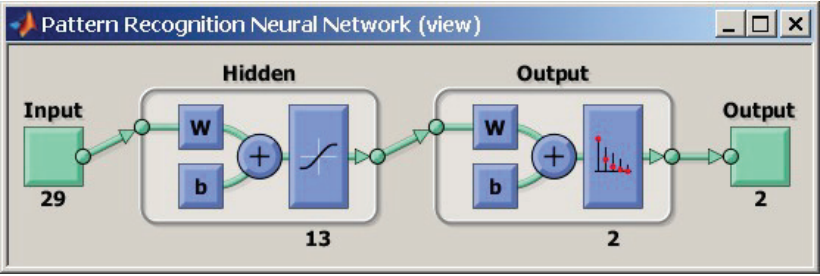

In [17]:
DEVICE

device(type='cuda')

In [16]:
class NN(nn.Module):
    def __init__(self, input_size, output_dim):
        super(NN, self).__init__()

        self.body = nn.Sequential(
            nn.Linear(input_size, 13),
            nn.ReLU(),
            nn.Linear(13, output_dim),

        )
        self.sig = nn.Sigmoid()
       
    def forward(self, x):
        logits = self.body(x)
        #print(logits.shape)
        #logits = torch.tensor(torch.argmax(logits, dim=1).type(torch.float32), requires_grad=True)
        #clf = self.sig(logits)
        #print(logits)
        #clf = torch.tensor(torch.argmax(enc, dim=1).type(torch.float32), requires_grad=True)

        return logits.view(-1)
    
    def predict(self, x):
        y_logit = self.forward(x)
        y_probs = self.sig(y_logit)#.detach().cpu().numpy()
        return y_probs

# <span style='background-color: #D6F99B'>Приступим к обучению </span>

In [65]:
sample_size = X_train.shape[1]
output_dim = 1
lr = 5e-3

model = NN(sample_size, output_dim).to(DEVICE)
#criterion = nn.MSELoss()
criterion = nn.BCEWithLogitsLoss() #nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-4)
#optimizer = SGD(model.parameters(), lr=lr, momentum=0.95)
# Обучим 38 эпох
epochs = 250

In [66]:
#from functools import lru_cache

In [67]:
#@lru_cache(maxsize=128, typed=list)
def plot_results(loss_history, accuracy_history, recall_hist):
    loss_iters = len(loss_history)
    x = np.arange(1, loss_iters+1)
    #x_acc = np.arange(0, len(accuracy_history))
    # Визуализируем полученные данные

    plt.figure(figsize=[5, 10])
    plt.subplot(3, 1, 1)
    plt.title("Mean loss")
    plt.plot(x, loss_history)
    plt.grid()

    plt.subplot(3, 1, 2)
    plt.title("Accuracy by validation")
    plt.plot(x, accuracy_history)
    plt.grid()
    
    plt.subplot(3, 1, 3)
    plt.title("Recall by validation")
    plt.plot(x, recall_hist)
    plt.grid()
    plt.show()

In [68]:
def train(model, criterion, optimizer, epochs):
    metric = BinaryAccuracy().to(DEVICE)
    recall = BinaryRecall().to(DEVICE)
    
    loss_CLF_history, accuracy_history = [], []
    recall_hist = []
    
    for epoch in trange(epochs):
        clf_running = 0
        for (x_batch, y_batch) in train_loader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            
            y_pred = model(x_batch)
            #pred_probab = nn.Softmax(dim=1)(logits)
            #print(y_pred, y_batch)
            #y_pred = torch.tensor(logits.argmax(1).type(torch.float32), requires_grad=True)
            
            
            # Ошибка для NN
            #print(y_pred, y_batch)
            #clf = torch.tensor(clf, requires_grad=True)
            loss = criterion(y_pred, y_batch)
            #print(loss)
            
            #return
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()           
            clf_running += loss.item()
            

        loss_CLF_history.append(clf_running)
        
        if (epoch % 1) == 0:
            accuracy_scr_batch = []
            recall_scr_batch = []
            
            for (x_val, y_val) in val_loader:
                x_val = x_val.to(DEVICE)
                y_val = y_val.to(DEVICE)
                pred = model.predict(x_val)
                #pred_probab = nn.Softmax(dim=1)(logits)
                #pred = pred_probab.argmax(1)
                
                # Считаем метрики
                metric.update(pred, y_val)
                #recall(pred, y_val)
                accuracy_scr_batch.append(metric.compute().item())
                recall_scr_batch.append(recall(pred, y_val).item())
                
            accuracy_history.append(np.mean(np.array(accuracy_scr_batch)))
            recall_hist.append(np.mean(np.array(recall_scr_batch)))
            
            clear_output()
            print('loss', loss_CLF_history[-1])
            print('accuracy', accuracy_history[-1])
            print('recall', recall_hist[-1])
            plot_results(loss_CLF_history, accuracy_history, recall_hist)

loss 3.9520357102155685
accuracy 0.7950926780700683
recall 0.9487109065055848


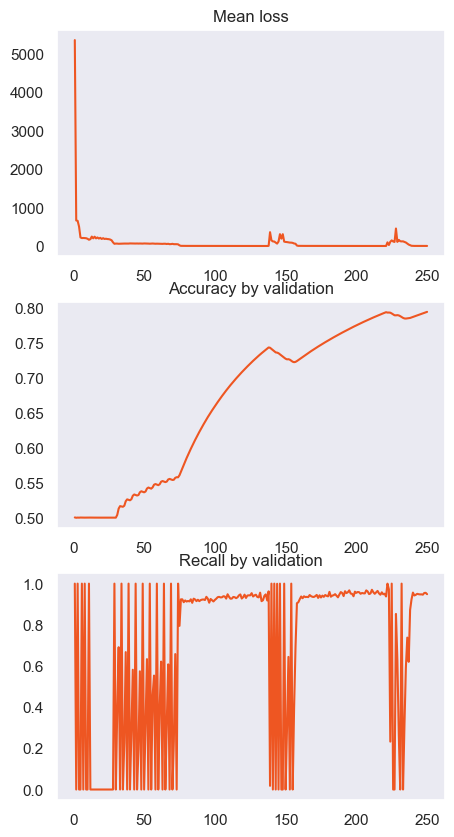

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [28:32<00:00,  6.85s/it]


In [69]:
train(model, criterion, optimizer, epochs)

In [70]:
# Сохраним модель
torch.save(model, f'{m_ccf_path}/NN.pt')

In [71]:
# Загрузим модель
model = torch.load( f'{m_ccf_path}/NN.pt')
model.eval()

NN(
  (body): Sequential(
    (0): Linear(in_features=30, out_features=13, bias=True)
    (1): ReLU()
    (2): Linear(in_features=13, out_features=1, bias=True)
  )
  (sig): Sigmoid()
)

In [72]:
test_dataset = TensorDataset(
              torch.tensor(X_test.astype(np.float32)),
              torch.tensor(y_test.astype(np.float32)))


# Даталодер
test_loader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)

In [73]:
def get_prediction(model, d_loader):
    #s = nn.Sigmoid()
    #predictions = []
    for batch in d_loader:
        x_batch = batch[0].to(DEVICE)
        s = model(x_batch)
        #print(s)
        clf = model.predict(x_batch).detach().cpu().numpy()
        #print(clf)
        #clf = s(clf)
        #predictions = clf.detach().cpu().numpy()
  
    #predictions = np.concatenate(predictions)

    return clf

In [74]:
get_prediction(model, test_loader)

[9.0433802e-13 3.3928125e-14 3.1337134e-13 ... 6.7979465e-18 3.4904193e-17
 3.3266992e-15]


array([9.0433802e-13, 3.3928125e-14, 3.1337134e-13, ..., 6.7979465e-18,
       3.4904193e-17, 3.3266992e-15], dtype=float32)

In [75]:
test_pred = get_prediction(model, test_loader).astype('int64')

[9.0433802e-13 3.3928125e-14 3.1337134e-13 ... 6.7979465e-18 3.4904193e-17
 3.3266992e-15]


In [80]:
test_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [81]:
np.sum(test_pred)

65

In [82]:
np.sum(y_test)

52

## Оценим результаты модели

In [83]:
metrics.show_metrics(y_test, test_pred)

True positive rate (recall):  0.75
False positive rate:  0.0006055101422948834
Precision:  0.6
Recall:  0.75
True negative rate:  0.9993944898577051
ROC-AUC:  0.8746972449288526
F1:  0.6666666666666666
MCC:  0.6703802967135541
G-mean:  0.8657631704994609


In [84]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42939
           1       0.60      0.75      0.67        52

    accuracy                           1.00     42991
   macro avg       0.80      0.87      0.83     42991
weighted avg       1.00      1.00      1.00     42991



## Метрика MCC невероятно большая для такой простой модели - 0.67

## Попробуем TabNetClassifier

In [8]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

In [26]:
# define the model
clf= TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       scheduler_params={"step_size":10, 
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                      )

# fit the model 
clf.fit(
    X_tr_sm, y_tr_sm,
    eval_set=[(X_tr_sm, y_tr_sm), (X_val_sm, y_val_sm)],
    eval_name=['train', 'val'],
    eval_metric=['auc','balanced_accuracy'],
    max_epochs=200, patience=60,
    batch_size=21359, virtual_batch_size=21359,
    num_workers=0,
    weights=1,
    drop_last=False
)    

epoch 0  | loss: 0.31506 | train_auc: 0.9201  | train_balanced_accuracy: 0.69587 | val_auc: 0.91987 | val_balanced_accuracy: 0.72534 |  0:00:07s
epoch 1  | loss: 0.09589 | train_auc: 0.95454 | train_balanced_accuracy: 0.63699 | val_auc: 0.94985 | val_balanced_accuracy: 0.70995 |  0:00:15s
epoch 2  | loss: 0.07022 | train_auc: 0.98251 | train_balanced_accuracy: 0.65005 | val_auc: 0.98094 | val_balanced_accuracy: 0.74218 |  0:00:23s
epoch 3  | loss: 0.05799 | train_auc: 0.99107 | train_balanced_accuracy: 0.73802 | val_auc: 0.98234 | val_balanced_accuracy: 0.8354  |  0:00:31s
epoch 4  | loss: 0.04866 | train_auc: 0.99359 | train_balanced_accuracy: 0.79702 | val_auc: 0.97903 | val_balanced_accuracy: 0.87776 |  0:00:40s
epoch 5  | loss: 0.04346 | train_auc: 0.99276 | train_balanced_accuracy: 0.80299 | val_auc: 0.97688 | val_balanced_accuracy: 0.88884 |  0:00:48s
epoch 6  | loss: 0.03718 | train_auc: 0.99609 | train_balanced_accuracy: 0.89162 | val_auc: 0.98354 | val_balanced_accuracy: 0.937

epoch 57 | loss: 0.00396 | train_auc: 0.99993 | train_balanced_accuracy: 0.99896 | val_auc: 0.99369 | val_balanced_accuracy: 0.92792 |  0:07:34s
epoch 58 | loss: 0.00423 | train_auc: 0.99995 | train_balanced_accuracy: 0.99885 | val_auc: 0.99436 | val_balanced_accuracy: 0.92814 |  0:07:41s
epoch 59 | loss: 0.00358 | train_auc: 0.99996 | train_balanced_accuracy: 0.99953 | val_auc: 0.99339 | val_balanced_accuracy: 0.91763 |  0:07:49s
epoch 60 | loss: 0.00343 | train_auc: 0.99996 | train_balanced_accuracy: 0.99922 | val_auc: 0.99403 | val_balanced_accuracy: 0.9148  |  0:07:57s
epoch 61 | loss: 0.00364 | train_auc: 0.99996 | train_balanced_accuracy: 0.99921 | val_auc: 0.99336 | val_balanced_accuracy: 0.91977 |  0:08:05s
epoch 62 | loss: 0.0035  | train_auc: 0.99996 | train_balanced_accuracy: 0.99937 | val_auc: 0.99413 | val_balanced_accuracy: 0.92085 |  0:08:13s
epoch 63 | loss: 0.00462 | train_auc: 0.99995 | train_balanced_accuracy: 0.99904 | val_auc: 0.99232 | val_balanced_accuracy: 0.927

In [27]:
with open(f'{m_ccf_path}/TabNet.pkl', 'wb') as fp:
    pickle.dump(clf, fp)

In [28]:
test_pred = clf.predict(X_test)

In [29]:
test_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [30]:
metrics.show_metrics(y_test, test_pred)

True positive rate (recall):  0.7884615384615384
False positive rate:  0.01830503737860686
Precision:  0.049576783555018135
Recall:  0.7884615384615384
True negative rate:  0.9816949626213931
ROC-AUC:  0.8850782505414658
F1:  0.09328782707622298
MCC:  0.19488704179470898
G-mean:  0.8797890204636598


## Хорошие результаты

# <span style='background-color: #D6F99B'>Попробуем CNN</span>

In [8]:
# Данные
path_ccf = "D:\Work_dir\Master_work\Data\Credit_Card_Fraud_Detection"

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = data.prep_data_ccf(path_ccf)

### В оригинальной статье используется SMOTE для балансировки данных

In [10]:
from imblearn.over_sampling import SMOTE

In [11]:
sm = SMOTE(random_state=42)
X_tr_sm, y_tr_sm = sm.fit_resample(X_train, y_train)

In [12]:
X_val_sm, y_val_sm = sm.fit_resample(X_val, y_val)

In [13]:
train_dataset = TensorDataset(
              torch.tensor(X_tr_sm.astype(np.float32)),
              torch.tensor(y_tr_sm.astype(np.float32)))

val_dataset = TensorDataset(
              torch.tensor(X_val_sm.astype(np.float32)),
              torch.tensor(y_val_sm.astype(np.float32)))

#test_dataset = TensorDataset(
#              torch.tensor(X_test.astype(np.float32)),
#              torch.tensor(y_test.astype(np.float32)))

In [14]:
a = []
b = []
c = []
for i in range(1, X_tr_sm.shape[0]+1):
    if X_tr_sm.shape[0] % i == 0:
        a.append(i)
    if (X_tr_sm.shape[0] % i == 0) and (X_val_sm.shape[0] % i == 0):
        b.append(i)
    if (X_tr_sm.shape[0] % i == 0) and (X_test.shape[0] % i == 0):
        c.append(i)
a

[1,
 2,
 4,
 13,
 26,
 47,
 52,
 94,
 157,
 188,
 314,
 611,
 628,
 1222,
 2041,
 2444,
 4082,
 7379,
 8164,
 14758,
 29516,
 95927,
 191854,
 383708]

In [15]:
batch_size = 4082

In [17]:
# Даталодер
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
class CNN(nn.Module):
    def __init__(self, input_size, output_dim):
        super(CNN, self).__init__()

        self.prepare = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1024),
            nn.ReLU(),
            nn.Linear(1024, 4096),
            nn.ReLU()
        )
        
        self.body_1 = nn.Sequential(
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=1),
            nn.ReLU(),
        )
        
        self.body_2 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=1),
            nn.ReLU(),
        )
        
        self.flatten = nn.Flatten()
        
        self.fully = nn.Sequential(                
            nn.Linear(16256, 128),      
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
        )
        self.sig = nn.Sigmoid()
       
    def forward(self, x):
        prepare = self.prepare(x)
        x = prepare.reshape(x.shape[0], 16, 256)
        x_s = self.body_1(x)
        
        x_b = self.body_2(x_s)
        #print(x_b.shape, x_s.shape)
        x_f = x_b + x_s # res
        logits = self.flatten(x_f)
        
        #print(logits.shape)
        clf = self.fully(logits)
        #print(clf.shape)
        #clf = torch.tensor(torch.argmax(clf, dim=1).type(torch.float32), requires_grad=True) #float32

        return clf.view(-1)
    
    def predict(self, x):
        y_logit = self.forward(x)
        y_probs = self.sig(y_logit)#.detach().cpu().numpy()
        return y_probs

In [98]:
sample_size = X_train.shape[1]
output_dim = 1
lr = 0.1

model = CNN(sample_size, output_dim).to(DEVICE)
#criterion = nn.MSELoss()
criterion = nn.BCEWithLogitsLoss() #nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
#optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-4)
optimizer = SGD(model.parameters(), lr=lr, momentum=0.9)
# Обучим 38 эпох
epochs = 400

In [99]:
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=3,mode="exp_range",gamma=0.85)

In [100]:
def plot_results(loss_history, accuracy_history, recall_hist):
    loss_iters = len(loss_history)
    x = np.arange(1, loss_iters+1)
    # Визуализируем полученные данные

    plt.figure(figsize=[5, 10])
    plt.subplot(3, 1, 1)
    plt.title("Mean loss")
    plt.plot(x, loss_history)
    plt.grid()

    plt.subplot(3, 1, 2)
    plt.title("Accuracy by validation")
    plt.plot(x, accuracy_history)
    plt.grid()
    
    plt.subplot(3, 1, 3)
    plt.title("Recall by validation")
    plt.plot(x, recall_hist)
    plt.grid()
    plt.show()

In [101]:
def train(model, criterion, optimizer, epochs, scheduler):
    metric = BinaryAccuracy().to(DEVICE)
    recall = BinaryRecall().to(DEVICE)
    
    loss_CLF_history, accuracy_history = [], []
    recall_hist = []
    
    for epoch in trange(epochs):
        clf_running = 0
        for (x_batch, y_batch) in train_loader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            
            y_pred = model(x_batch)            
            
            # Ошибка для CNN
            loss = criterion(y_pred, y_batch)
            
            #return
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            clf_running += loss.item()
            
        scheduler.step()
        loss_CLF_history.append(clf_running)
        
        if (epoch % 1) == 0:
            accuracy_scr_batch = []
            recall_scr_batch = []
            
            for (x_val, y_val) in train_loader:
                x_val = x_val.to(DEVICE)
                y_val = y_val.to(DEVICE)
                pred = model.predict(x_val)
                
                # Считаем метрики
                metric.update(pred, y_val)
                accuracy_scr_batch.append(metric.compute().item())
                recall_scr_batch.append(recall(pred, y_val).item())
                
            accuracy_history.append(np.mean(np.array(accuracy_scr_batch)))
            recall_hist.append(np.mean(np.array(recall_scr_batch)))
            
            clear_output()
            print('loss', loss_CLF_history[-1])
            print('accuracy', accuracy_history[-1])
            print('recall', recall_hist[-1])
            plot_results(loss_CLF_history, accuracy_history, recall_hist)

loss 55.810218036174774
accuracy 0.639802061496897
recall 0.756324237965523


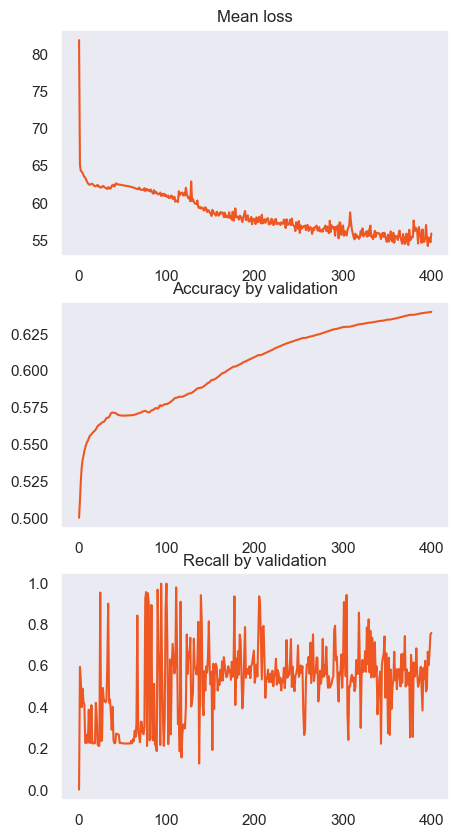

100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [1:46:29<00:00, 15.97s/it]


In [102]:
train(model, criterion, optimizer, epochs, scheduler)

In [103]:
# Сохраним модель
torch.save(model, f'{m_ccf_path}/CNN.pt')

In [104]:
# Загрузим модель
model = torch.load( f'{m_ccf_path}/CNN.pt')
model.eval()

CNN(
  (prepare): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=4096, bias=True)
    (5): ReLU()
  )
  (body_1): Sequential(
    (0): Conv1d(16, 32, kernel_size=(2,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(2,), stride=(1,))
    (3): ReLU()
    (4): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (5): ReLU()
    (6): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (7): ReLU()
  )
  (body_2): Sequential(
    (0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (3): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fully): Sequential(
    (0): Linear(in_features=16256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_fea

In [105]:
test_dataset = TensorDataset(
              torch.tensor(X_test.astype(np.float32)),
              torch.tensor(y_test.astype(np.float32)))


# Даталодер
test_loader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)

In [106]:
def get_prediction(model, d_loader):

    for batch in d_loader:
        x_batch = batch[0].to(DEVICE)
        clf = model.predict(x_batch).detach().cpu().numpy()
        #print(clf)

    return clf

In [107]:
get_prediction(model, test_loader)

array([0.7571341 , 0.7558175 , 0.7555505 , ..., 0.9174478 , 0.91640407,
       0.9198153 ], dtype=float32)

In [108]:
test_pred = get_prediction(model, test_loader).astype('int64')

In [109]:
test_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [110]:
np.sum(test_pred)

0

In [111]:
np.sum(y_test)

52

## Оценим результаты модели

In [112]:
metrics.show_metrics(y_test, test_pred)

True positive rate (recall):  0.0
False positive rate:  0.0
Precision:  nan
Recall:  0.0
True negative rate:  1.0
ROC-AUC:  0.5
F1:  0.0
MCC:  nan
G-mean:  0.0


In [113]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42939
           1       0.00      0.00      0.00        52

    accuracy                           1.00     42991
   macro avg       0.50      0.50      0.50     42991
weighted avg       1.00      1.00      1.00     42991



# Обучим свою модель

In [8]:
# Данные
path_ccf = "D:\Work_dir\Master_work\Data\Credit_Card_Fraud_Detection"

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = data.prep_data_ccf(path_ccf)

### В оригинальной статье используется SMOTE для балансировки данных

In [10]:
from imblearn.over_sampling import SMOTE

In [11]:
sm = SMOTE(random_state=42)
X_tr_sm, y_tr_sm = sm.fit_resample(X_train, y_train)

In [12]:
X_val_sm, y_val_sm = sm.fit_resample(X_val, y_val)

In [13]:
train_dataset = TensorDataset(
              torch.tensor(X_tr_sm.astype(np.float32)),
              torch.tensor(y_tr_sm.astype(np.float32)))

val_dataset = TensorDataset(
              torch.tensor(X_val_sm.astype(np.float32)),
              torch.tensor(y_val_sm.astype(np.float32)))

#test_dataset = TensorDataset(
#              torch.tensor(X_test.astype(np.float32)),
#              torch.tensor(y_test.astype(np.float32)))

In [14]:
a = []
for i in range(1, X_tr_sm.shape[0]+1):
    if X_tr_sm.shape[0] % i == 0:
        a.append(i)
a

[1,
 2,
 4,
 13,
 26,
 47,
 52,
 94,
 157,
 188,
 314,
 611,
 628,
 1222,
 2041,
 2444,
 4082,
 7379,
 8164,
 14758,
 29516,
 95927,
 191854,
 383708]

In [15]:
batch_size = 14758

In [16]:
# Даталодер
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
class Our_Model(nn.Module):
    def __init__(self, input_size, output_size):
        super(Our_Model, self).__init__()
        
        # Энкодер
        self.ae = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 512),
            nn.ReLU(),
            nn.Linear(512, input_size)
        )
        
        # Декодер
        #self.decoder = nn.Sequential(
        #    nn.Linear(16, 64),
        #    nn.ReLU(),
        #    nn.Linear(64, 512),
        #    nn.ReLU(),
        #    #nn.Linear(512, 3904),
        #    #nn.ReLU(),
        #    nn.Linear(512, input_size)
        #)
        
       
        # Определим голову для обучения классификатора
        self.classifier_head = nn.Sequential(
            nn.Linear(input_size*2, 13),
            #nn.ReLU(),
            #nn.Linear(512, 256),
            #nn.ReLU(),
            #nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(13, output_size)
            )
        
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        ae = self.ae(x)
        #dec = self.decoder(enc)
        
        # Получаем разность Выхода и входа Автоэнкодера
        x_d = ae - x
        # Конкатенируем полученную Разность и исходные данные
        x_hidden = torch.cat((x, x_d),dim=1)
        # Обучаем классификатор
        clf_head = self.classifier_head(x_hidden)
        return clf_head.view(-1)
    
    def predict(self, x):
        
        y_logit = self.forward(x)
        y_probs = self.sigm(y_logit)
        return y_probs

In [188]:
sample_size = X_train.shape[1]
output_size = 1
lr = 0.1

model = Our_Model(sample_size, output_size).to(DEVICE)

#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-4)
#optimizer = SGD(model.parameters(), lr=lr, momentum=0.9)

epochs = 400

In [191]:
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=2,mode="exp_range",gamma=0.85, cycle_momentum=True)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=2, epochs=epochs)

In [192]:
def plot_results(loss_history, accuracy_history, recall_hist):
    loss_iters = len(loss_history)
    x = np.arange(1, loss_iters+1)
    # Визуализируем полученные данные

    plt.figure(figsize=[5, 10])
    plt.subplot(3, 1, 1)
    plt.title("Mean loss")
    plt.plot(x, loss_history)
    plt.grid()

    plt.subplot(3, 1, 2)
    plt.title("Accuracy by validation")
    plt.plot(x, accuracy_history)
    plt.grid()
    
    plt.subplot(3, 1, 3)
    plt.title("Recall by validation")
    plt.plot(x, recall_hist)
    plt.grid()
    plt.show()

In [193]:
def train(model, criterion, optimizer, epochs, scheduler):
    metric = BinaryAccuracy().to(DEVICE)
    recall = BinaryRecall().to(DEVICE)
    
    loss_CLF_history, accuracy_history = [], []
    recall_hist = []
    
    for epoch in trange(epochs):
        clf_running = 0
        for (x_batch, y_batch) in train_loader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            
            y_pred = model(x_batch)            
            
            # Ошибка для CNN
            loss = criterion(y_pred, y_batch)
            
            #return
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            clf_running += loss.item()
            
        scheduler.step()
        loss_CLF_history.append(clf_running)
        
        if (epoch % 1) == 0:
            accuracy_scr_batch = []
            recall_scr_batch = []
            
            for (x_val, y_val) in train_loader:
                x_val = x_val.to(DEVICE)
                y_val = y_val.to(DEVICE)
                pred = model.predict(x_val)
                
                # Считаем метрики
                metric.update(pred, y_val)
                accuracy_scr_batch.append(metric.compute().item())
                recall_scr_batch.append(recall(pred, y_val).item())
                
            accuracy_history.append(np.mean(np.array(accuracy_scr_batch)))
            recall_hist.append(np.mean(np.array(recall_scr_batch)))
            
            clear_output()
            print('loss', loss_CLF_history[-1])
            print('accuracy', accuracy_history[-1])
            print('recall', recall_hist[-1])
            plot_results(loss_CLF_history, accuracy_history, recall_hist)

loss 1841710.28125
accuracy 0.6053884625434875
recall 1.0


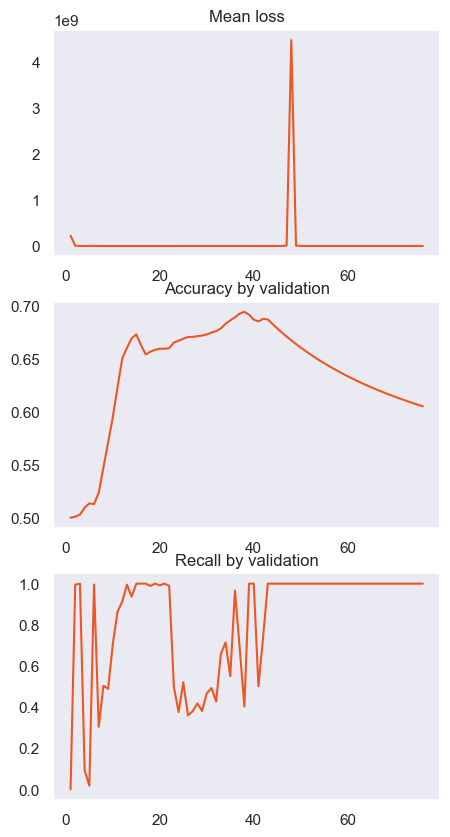

 19%|███████████████                                                                | 76/400 [15:12<1:04:50, 12.01s/it]


KeyboardInterrupt: 

In [194]:
train(model, criterion, optimizer, epochs, scheduler)

# Похоже что так это не работает

# Попробуем предварительно обучить Автоэнкодер

In [98]:
class AE(nn.Module):
    def __init__(self, input_size):
        super(AE, self).__init__()
        
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 512),
            nn.ReLU(),
            nn.Linear(512, input_size)
        )

    def forward(self, x):
        x_e = self.encoder(x)
        res = self.decoder(x_e)
        return res

In [99]:
sample_size = X_train.shape[1]
lr = 0.005
model = AE(sample_size).to(DEVICE)
#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss()#nn.BCELoss()
#criterion = nn.BCELoss()
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-4)
#optimizer = SGD(model.parameters(), lr=lr, momentum=0.9)
epochs = 20

In [100]:
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=2,mode="exp_range",gamma=0.85, cycle_momentum=True)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=5, epochs=epochs)

In [101]:
def plot_results(loss_history_AE):
    iters = len(loss_history_AE)
    x = np.arange(1, iters+1)
    # Визуализируем полученные данные

    plt.figure(figsize=[5, 5])
    plt.title("Mean AE loss")
    plt.plot(x, loss_history_AE)
    plt.grid()

    plt.show()

In [102]:
def train(model, criterion, optimizer, epochs, scheduler):

    loss_AE_history = []

    for epoch in trange(epochs):
        running_loss = 0
        for (x_batch, y_batch) in train_loader:
            x_batch = x_batch.to(DEVICE)
            
            ae = model(x_batch)
            # Ошибка для AE
            loss = criterion(ae, x_batch)
           
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()    
        loss_AE_history.append(running_loss)
        clear_output()
        print(loss_AE_history[-1])
        plot_results(loss_AE_history)

950930024.0


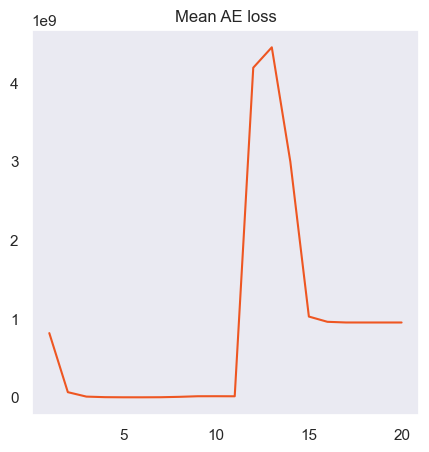

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:04<00:00,  6.20s/it]


In [103]:
train(model, criterion, optimizer, epochs, scheduler)

In [104]:
# Сохраним модель
torch.save(model, f'{m_ccf_path}/AE.pt')

In [105]:
# Загрузим модель
model = torch.load( f'{m_ccf_path}/AE.pt')
model.eval()

AE(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=30, bias=True)
  )
)

# Обучим классификатор

In [106]:
for param in model.parameters():
    param.requires_grad = False

In [107]:
model

AE(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=30, bias=True)
  )
)

In [122]:
class Our_Model(nn.Module):
    def __init__(self, input_size, output_size):
        super(Our_Model, self).__init__()
       
        # Определим голову для обучения классификатора
        self.classifier_head = nn.Sequential(
            nn.Linear(input_size*2, 256),
            nn.ReLU(),
            
            nn.BatchNorm1d(256, momentum=0.1),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            
            nn.BatchNorm1d(64, momentum=0.1),
            nn.Dropout(0.2),
            nn.Linear(64, output_size),
            )
        
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        #print(x.shape)
        clf_head = self.classifier_head(x)
        return clf_head.view(-1)
    
    def predict(self, x):
        y_logit = self.forward(x)
        y_probs = self.sigm(y_logit)
        return y_probs

In [123]:
input_size = X_train.shape[1]
output_size = 1
lr = 0.001

model_ae = model.to(DEVICE)
model_clf = Our_Model(input_size, output_size).to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
#optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-4)
optimizer = SGD(model.parameters(), lr=lr, momentum=0.9)

epochs = 400

In [124]:
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=5,mode="exp_range",gamma=0.85, cycle_momentum=True)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=2, epochs=epochs)

In [125]:
def plot_results(loss_history, accuracy_history, recall_hist):
    loss_iters = len(loss_history)
    x = np.arange(1, loss_iters+1)
    # Визуализируем полученные данные

    plt.figure(figsize=[5, 10])
    plt.subplot(3, 1, 1)
    plt.title("Mean loss")
    plt.plot(x, loss_history)
    plt.grid()

    plt.subplot(3, 1, 2)
    plt.title("Accuracy by validation")
    plt.plot(x, accuracy_history)
    plt.grid()
    
    plt.subplot(3, 1, 3)
    plt.title("Recall by validation")
    plt.plot(x, recall_hist)
    plt.grid()
    plt.show()

In [126]:
def train(model_ae, model_clf, criterion, optimizer, epochs, scheduler):
    metric = BinaryAccuracy().to(DEVICE)
    recall = BinaryRecall().to(DEVICE)
    
    loss_CLF_history, accuracy_history = [], []
    recall_hist = []
    
    for epoch in trange(epochs):
        clf_running = 0
        for (x_batch, y_batch) in train_loader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            
            # Получаем автоэнкодер            
            ae = model_ae(x_batch)
            
            # Получаем разность Выхода и входа Автоэнкодера
            x_d = ae - x_batch
            
            # Конкатенируем полученную Разность и исходные данные
            x_hidden = torch.cat((x_batch, x_d), dim=1)
            
            #print(x_hidden.shape)
            # Обучаем классификатор
            y_pred = model_clf(x_hidden)            
            
            # Ошибка для CNN
            loss = criterion(y_pred, y_batch)
            
            #return
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            clf_running += loss.item()
            
        scheduler.step()
        loss_CLF_history.append(clf_running)
        
        if (epoch % 1) == 0:
            accuracy_scr_batch = []
            recall_scr_batch = []
            
            for (x_val, y_val) in train_loader:
                x_val = x_val.to(DEVICE)
                y_val = y_val.to(DEVICE)
                ae = model_ae(x_val)
            
                # Получаем разность Выхода и входа Автоэнкодера
                x_d = ae - x_val

                # Конкатенируем полученную Разность и исходные данные
                x_hidden = torch.cat((x_val, x_d), dim=1)
                
                pred = model_clf.predict(x_hidden)
                
                # Считаем метрики
                metric.update(pred, y_val)
                accuracy_scr_batch.append(metric.compute().item())
                recall_scr_batch.append(recall(pred, y_val).item())
                
            accuracy_history.append(np.mean(np.array(accuracy_scr_batch)))
            recall_hist.append(np.mean(np.array(recall_scr_batch)))
            
            clear_output()
            print('loss', loss_CLF_history[-1])
            print('accuracy', accuracy_history[-1])
            print('recall', recall_hist[-1])
            plot_results(loss_CLF_history, accuracy_history, recall_hist)

loss 19.935992896556854
accuracy 0.513148158788681
recall 0.36732682356467616


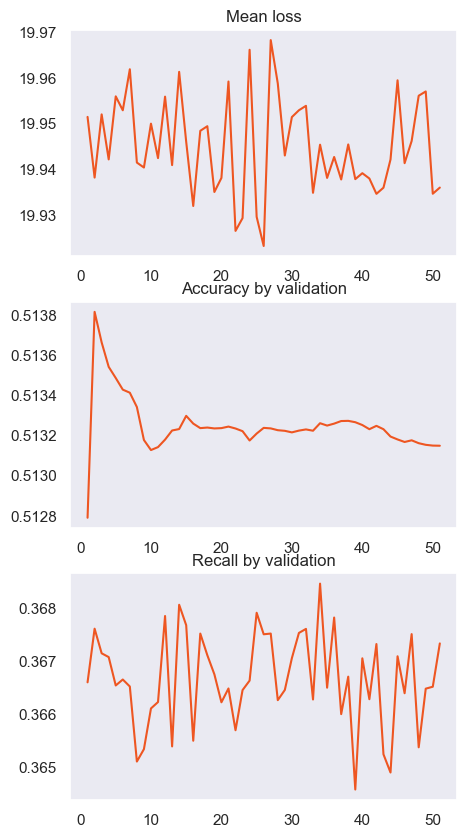

 13%|██████████                                                                     | 51/400 [10:26<1:11:24, 12.28s/it]


KeyboardInterrupt: 

In [127]:
train(model_ae, model_clf, criterion, optimizer, epochs, scheduler)

# Так тоже не работает попробуем повторно

# Повторное обучение встроенного автоэнкодера

In [13]:
# Данные
path_ccf = "D:\Work_dir\Master_work\Data\Credit_Card_Fraud_Detection"

In [14]:
X_train, y_train, X_val, y_val, X_test, y_test = data.prep_data_ccf(path_ccf)

In [15]:
from imblearn.over_sampling import SMOTE

In [16]:
sm = SMOTE(random_state=42)
X_tr_sm, y_tr_sm = sm.fit_resample(X_train, y_train)

In [17]:
X_val_sm, y_val_sm = sm.fit_resample(X_val, y_val)

In [18]:
train_dataset = TensorDataset(
              torch.tensor(X_tr_sm.astype(np.float32)),
              torch.tensor(y_tr_sm.astype(np.float32)))

val_dataset = TensorDataset(
              torch.tensor(X_val_sm.astype(np.float32)),
              torch.tensor(y_val_sm.astype(np.float32)))

#test_dataset = TensorDataset(
#              torch.tensor(X_test.astype(np.float32)),
#              torch.tensor(y_test.astype(np.float32)))

In [19]:
a = []
for i in range(1, X_tr_sm.shape[0]+1):
    if X_tr_sm.shape[0] % i == 0:
        a.append(i)
a

[1,
 2,
 4,
 13,
 26,
 47,
 52,
 94,
 157,
 188,
 314,
 611,
 628,
 1222,
 2041,
 2444,
 4082,
 7379,
 8164,
 14758,
 29516,
 95927,
 191854,
 383708]

In [20]:
batch_size = 8164

In [21]:
# Даталодер
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
class Our_Model(nn.Module):
    def __init__(self, input_size, output_size):
        super(Our_Model, self).__init__()
        
        # Энкодер
        self.ae = nn.Sequential(
            nn.Linear(input_size, 8192),
            nn.ReLU(),
            nn.Linear(8192, 512),
            nn.ReLU(),
            nn.Linear(512, 16),
            nn.ReLU(),
            
            nn.Linear(16, 512),
            nn.ReLU(),
            nn.Linear(512, 8192),
            nn.ReLU(),
            nn.Linear(8192, input_size)
        )


        # Определим голову для обучения классификатора      
        self.classifier_head = nn.Sequential(
            nn.Linear(input_size*2, 512),
            nn.ReLU(),
            
            nn.BatchNorm1d(512, momentum=0.1),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(64, output_size),
            )
        
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        ae = self.ae(x)
        # Получаем разность Выхода и входа Автоэнкодера
        x_d = ae - x
        # Конкатенируем полученную Разность и исходные данные
        x_hidden = torch.cat((x, x_d),dim=1)
        # Обучаем классификатор
        clf_head = self.classifier_head(x_hidden)
        return clf_head.view(-1)
    
    def predict(self, x):
        
        y_logit = self.forward(x)
        y_probs = self.sigm(y_logit)
        return y_probs

In [148]:
sample_size = X_train.shape[1]
output_size = 1
lr = 0.001

model = Our_Model(sample_size, output_size).to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-4)
#optimizer = SGD(model.parameters(), lr=lr, momentum=0.8)

epochs = 400

In [149]:
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.4,step_size_up=2,mode="exp_range",gamma=0.85, cycle_momentum=True)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=2, epochs=epochs)

In [150]:
def plot_results(loss_history, accuracy_history, recall_hist):
    loss_iters = len(loss_history)
    x = np.arange(1, loss_iters+1)
    # Визуализируем полученные данные

    plt.figure(figsize=[5, 10])
    plt.subplot(3, 1, 1)
    plt.title("Mean loss")
    plt.plot(x, loss_history)
    plt.grid()

    plt.subplot(3, 1, 2)
    plt.title("Accuracy by validation")
    plt.plot(x, accuracy_history)
    plt.grid()
    
    plt.subplot(3, 1, 3)
    plt.title("Recall by validation")
    plt.plot(x, recall_hist)
    plt.grid()
    plt.show()

In [151]:
def train(model, criterion, optimizer, epochs, scheduler):
    metric = BinaryAccuracy().to(DEVICE)
    recall = BinaryRecall().to(DEVICE)
    
    loss_CLF_history, accuracy_history = [], []
    recall_hist = []
    
    for epoch in trange(epochs):
        clf_running = 0
        for (x_batch, y_batch) in train_loader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            
            y_pred = model(x_batch)            
            
            # Ошибка для CNN
            loss = criterion(y_pred, y_batch)
            
            #return
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            clf_running += loss.item()
            
        scheduler.step()
        loss_CLF_history.append(clf_running)
        
        if (epoch % 1) == 0:
            accuracy_scr_batch = []
            recall_scr_batch = []
            
            for (x_val, y_val) in train_loader:
                x_val = x_val.to(DEVICE)
                y_val = y_val.to(DEVICE)
                pred = model.predict(x_val)
                
                # Считаем метрики
                metric.update(pred, y_val)
                accuracy_scr_batch.append(metric.compute().item())
                recall_scr_batch.append(recall(pred, y_val).item())
                
            accuracy_history.append(np.mean(np.array(accuracy_scr_batch)))
            recall_hist.append(np.mean(np.array(recall_scr_batch)))
            
            clear_output()
            print('loss', loss_CLF_history[-1])
            print('accuracy', accuracy_history[-1])
            print('recall', recall_hist[-1])
            plot_results(loss_CLF_history, accuracy_history, recall_hist)

loss 18.022364914417267
accuracy 0.5329516507112063
recall 0.9999843400258285


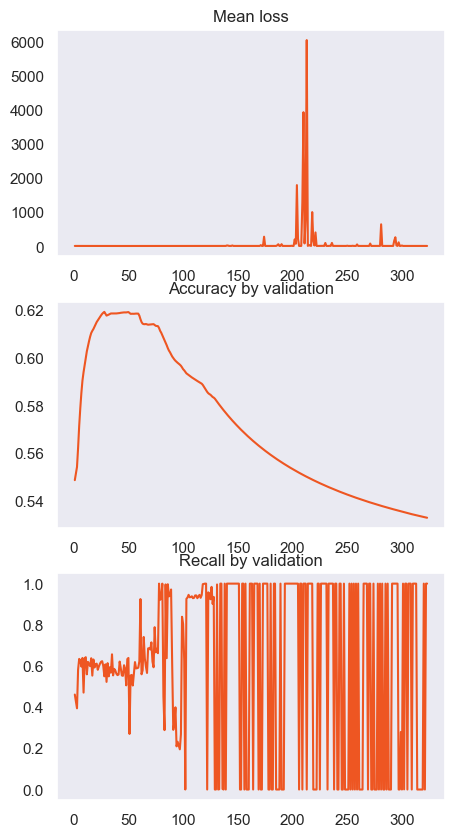

 81%|██████████████████████████████████████████████████████████████▉               | 323/400 [1:15:44<18:03, 14.07s/it]


KeyboardInterrupt: 

In [152]:
train(model, criterion, optimizer, epochs, scheduler)

# Продолжение экспериментов


In [6]:
class Our_Model_2(nn.Module):
    def __init__(self, input_size, output_size):
        super(Our_Model_2, self).__init__()
        
        # Энкодер
        self.ae = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512, momentum=0.1),
            nn.ReLU(),
            
            nn.Linear(512, 64),
            nn.BatchNorm1d(64, momentum=0.1),
            nn.ReLU(),
            
            nn.Linear(64, 16),
            nn.BatchNorm1d(16, momentum=0.1),
            nn.ReLU(),
            
            nn.Linear(16, 64),
            nn.BatchNorm1d(64, momentum=0.1),
            nn.ReLU(),
            
            nn.Linear(64, 512),
            nn.BatchNorm1d(512, momentum=0.6),
            nn.ReLU(),
            
            nn.Linear(512, input_size)
        )

        # Добавим нормализацию к исходным данным
        self.norm = nn.Sequential(
            nn.Linear(input_size, input_size),
            nn.BatchNorm1d(input_size, momentum=0.1)
        )
        
        # Определим голову для обучения классификатора      
        self.classifier_head = nn.Sequential(
            nn.Linear(input_size*2, 16),
            nn.BatchNorm1d(16, momentum=0.8),
            nn.ReLU(),

            nn.Linear(16, output_size),
            )
        
        self.sigm = nn.Sigmoid()


    def forward(self, x):
        ae = self.ae(x)
        # Получаем разность Выхода и входа Автоэнкодера
        x_d = ae - x
        # Исходные данные
        x_norm = self.norm(x)
        
        # Конкатенируем полученную Разность и исходные данные
        x_hidden = torch.cat((x_norm, x_d),dim=1)
        # Обучаем классификатор
        clf_head = self.classifier_head(x_hidden)
        return clf_head.view(-1)
    
    def predict(self, x): 
        y_logit = self.forward(x)
        y_probs = self.sigm(y_logit)

        return y_probs#.type(torch.int32)

In [236]:
def plot_results(loss_history, accuracy_history, recall_hist):
    loss_iters = len(loss_history)
    x = np.arange(1, loss_iters+1)
    # Визуализируем полученные данные

    plt.figure(figsize=[5, 10])
    plt.subplot(3, 1, 1)
    plt.title("Mean loss")
    plt.plot(x, loss_history)
    plt.grid()

    plt.subplot(3, 1, 2)
    plt.title("Accuracy by validation")
    plt.plot(x, accuracy_history)
    plt.grid()
    
    plt.subplot(3, 1, 3)
    plt.title("Recall by validation")
    plt.plot(x, recall_hist)
    plt.grid()
    plt.show()

In [328]:
def train(model, criterion, optimizer, epochs, scheduler):
    metric = BinaryAccuracy().to(DEVICE)
    recall = BinaryRecall().to(DEVICE)
    
    loss_CLF_history, accuracy_history = [], []
    recall_hist = []
    
    for epoch in trange(epochs):
        clf_running = 0
        for (x_batch, y_batch) in train_loader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            
            y_pred = model(x_batch)            
            
            # Ошибка для CNN
            loss = criterion(y_pred, y_batch)
            
            #return
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            clf_running += loss.item()
            
        scheduler.step()
        loss_CLF_history.append(clf_running)
        
        if (epoch % 1) == 0:
            accuracy_scr_batch = []
            recall_scr_batch = []
            
            for (x_val, y_val) in val_loader:
                x_val = x_val.to(DEVICE)
                y_val = y_val.to(DEVICE)
                pred = model.predict(x_val)#.type(torch.int32)

                # Считаем метрики
                metric.update(pred, y_val)

                accuracy_scr_batch.append(metric.compute().item())
                recall_scr_batch.append(recall(pred, y_val).item())
                
            accuracy_history.append(np.mean(np.array(accuracy_scr_batch)))
            recall_hist.append(np.mean(np.array(recall_scr_batch)))
            
            clear_output()
            print('loss', loss_CLF_history[-1])
            print('accuracy', accuracy_history[-1])
            print('recall', recall_hist[-1])
            plot_results(loss_CLF_history, accuracy_history, recall_hist)

In [238]:
sample_size = X_train.shape[1]
output_size = 1
lr = 0.008

model = Our_Model_2(sample_size, output_size).to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-4)
#optimizer = SGD(model.parameters(), lr=lr, momentum=0.8)

epochs = 60

In [205]:
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.09, max_lr=0.4,step_size_up=5,mode="exp_range",gamma=0.85, cycle_momentum=True)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.4, steps_per_epoch=5, epochs=epochs)

loss 31.05097508430481
accuracy 0.7544757540409381
recall 0.3998139271369347


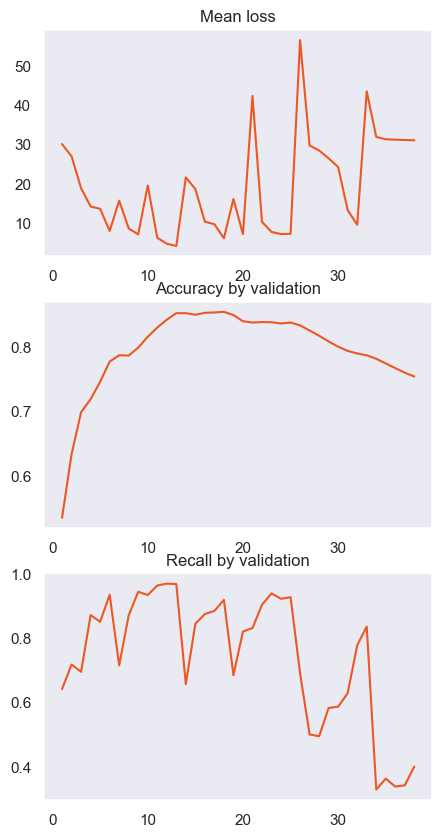

 63%|███████████████████████████████████████████████████▉                              | 38/60 [05:27<03:09,  8.63s/it]


KeyboardInterrupt: 

In [208]:
train(model, criterion, optimizer, epochs, scheduler)

In [329]:
sample_size = X_train.shape[1]
output_size = 1
lr = 0.004

model = Our_Model_2(sample_size, output_size).to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-4)
#optimizer = SGD(model.parameters(), lr=lr, momentum=0.8)

epochs = 160

In [330]:
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.09, max_lr=0.4,step_size_up=5,mode="exp_range",gamma=0.85, cycle_momentum=True)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=4, epochs=epochs)

loss 2.0680727399885654
accuracy 0.9245111483793992
recall 0.9960759694759662


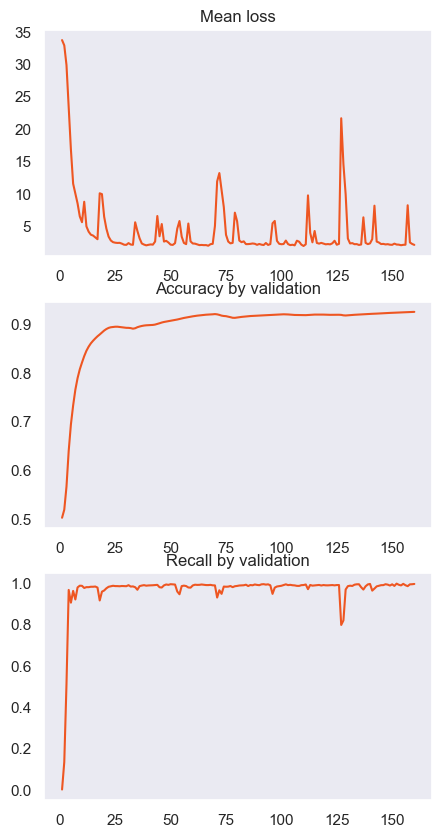

100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [22:45<00:00,  8.53s/it]


In [331]:
train(model, criterion, optimizer, epochs, scheduler)

In [332]:
# Сохраним модель
torch.save(model, f'{m_ccf_path}/AE_Data.pt')

In [7]:
# Загрузим модель
model = torch.load( f'{m_ccf_path}/AE_Data.pt')
model.eval()

Our_Model_2(
  (ae): Sequential(
    (0): Linear(in_features=30, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=16, bias=True)
    (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=16, out_features=64, bias=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=512, bias=True)
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.6, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=30, bias=True)
  )
  (norm): Sequential(
    (0): Linear(in_features=30, out_features

In [8]:
torch.save(model.state_dict(), f'{m_ccf_path}/Custom.pth')

In [10]:
model = Our_Model_2(30, 1)
model.load_state_dict(torch.load(f'{m_ccf_path}/Custom.pth'))
model.eval()

Our_Model_2(
  (ae): Sequential(
    (0): Linear(in_features=30, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=16, bias=True)
    (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=16, out_features=64, bias=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=512, bias=True)
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.6, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=30, bias=True)
  )
  (norm): Sequential(
    (0): Linear(in_features=30, out_features

In [334]:
test_dataset = TensorDataset(
              torch.tensor(X_test.astype(np.float32)),
              torch.tensor(y_test.astype(np.float32)))


# Даталодер
test_loader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)

In [341]:
from sklearn.metrics import accuracy_score

In [381]:
def get_prediction(model, d_loader):
    threshold=0.5
    for batch in d_loader:
        x_batch = batch[0].to(DEVICE)
        clf = model.predict(x_batch).detach().cpu().numpy()#type(torch.int32)
    
    clf[clf>threshold] = 1
    clf[clf<=0.5] = 0

    return clf

In [373]:
test_pred = get_prediction(model, test_loader)

In [374]:
test_pred

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [375]:
np.sum(test_pred)

38.0

In [376]:
np.sum(y_test)

52

In [383]:
def find_treshhold(pred, true_data):
    best_tresh = 0.5
    pos = np.copy(pred)
    pos[pos>best_tresh] = 1
    pos[pos<=best_tresh] = 0
    b_score = accuracy_score(pos, true_data)
    
    for i in range(0, 101):
        tmp = np.copy(pred)
        tresh = f'0.{i}'
        tmp[tmp>best_tresh] = 1
        tmp[tmp<=best_tresh] = 0
        #print(np.sum(tmp))
        s = accuracy_score(tmp, true_data)
        #print(f'0.{i}', s)
        if s > b_score:
            b_score = s
            best_tresh = tresh
    print(best_tresh)

In [384]:
find_treshhold(test_pred, y_test)

0.5


## Оценим результаты модели

In [385]:
metrics.show_metrics(y_test, test_pred)

True positive rate (recall):  0.7115384615384616
False positive rate:  2.3288851626726287e-05
Precision:  0.9736842105263158
Recall:  0.7115384615384616
True negative rate:  0.9999767111483733
ROC-AUC:  0.8557575863434175
F1:  0.8222222222222222
MCC:  0.8321914531160434
G-mean:  0.8435175698376437


# <span style='background-color: #D6F99B'>Подведение итогов</span>

In [28]:
X_train, y_train, X_val, y_val, X_test, y_test = data.prep_data_ccf(path_ccf)

In [29]:
names = ['AE_Data', 'CNN', 'NN', 'TabNet']

In [ ]:
with open(f'{m_ccf_path}/TabNet.pkl', 'wb') as fp:
    pickle.dump(clf, fp)

test_pred = clf.predict(X_test)

### Напишем цикл подсчета метрик

In [35]:
from base import metrics


test_dataset = TensorDataset(
              torch.tensor(X_test.astype(np.float32)),
              torch.tensor(y_test.astype(np.float32)))


# Даталодер
test_loader = DataLoader(test_dataset, batch_size=8000, shuffle=False)

def get_prediction(model, d_loader, y_test):
    """Функция predict
    Возвращает словарь для добавления в датафрейм"""
    
    threshold=0.5
    res = np.array([])
    first = True
    for batch in d_loader:
        x_batch = batch[0].to(DEVICE)
        clf = model.predict(x_batch).detach().cpu().numpy()
        if first:
            res = clf
            first = False
        else:
            res = np.hstack((res, clf))
    
    res[res>threshold] = 1
    res[res<=0.5] = 0

    recall_nf, recall_f, auc, f1, mcc, g_mean = metrics.write_metrics(y_test, res)
    tmp = {'Recall_not_fr':recall_nf,
            'Recall_fr':recall_f,
            'AUC':auc,
            'F1':f1,
            'MCC':mcc,
            'G_mean':g_mean}
    return tmp


def conclude_metrics(df, test_loader) -> pd.DataFrame:
    """
    INPUT: -> pd.DataFrame with zero data
                                      Recall_not_fr  Recall_fr  AUC  F1  MCC  G_mean

    OUTPUT: -> pd.DataFrame with full data of each models

    """
    
    models_names = os.listdir(m_ccf_path)
    
    for i in trange(len(models_names)):
        
        model = models_names[i]
        model_name = model.split('.')[0]

        if model_name == 'AE':
            continue
        
        elif model_name == 'TabNet':
            with open(f'{m_ccf_path}/{model_name}.pkl', 'rb') as fp:
                model = pickle.load(fp)

            test_pred = model.predict(X_test)
            recall_nf, recall_f, auc, f1, mcc, g_mean = metrics.write_metrics(y_test, test_pred)
            tmp = {'Recall_not_fr':recall_nf,
                    'Recall_fr':recall_f,
                    'AUC':auc,
                    'F1':f1,
                    'MCC':mcc,
                    'G_mean':g_mean}
            df.loc[f'{model_name}'] = tmp
        else:
            
            model = torch.load( f'{m_ccf_path}/{model}')
            model.eval()

            tmp = get_prediction(model, test_loader, y_test)
            df.loc[f'{model_name}'] = tmp
        
    return df

In [36]:
# Инициализируем Pandas DataFrame
results = pd.DataFrame(index=names, columns=['Recall_not_fr', 'Recall_fr', 'AUC', 'F1', 'MCC', 'G_mean'], data=0)
results

,Recall_not_fr,Recall_fr,AUC,F1,MCC,G_mean
AE_Data,0,0,0,0,0,0
CNN,0,0,0,0,0,0
NN,0,0,0,0,0,0
TabNet,0,0,0,0,0,0


In [37]:
res = conclude_metrics(results, test_loader)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


In [38]:
res

,Recall_not_fr,Recall_fr,AUC,F1,MCC,G_mean
AE_Data,0.999977,0.711538,0.855758,0.822222,0.832191,0.843518
CNN,0.000000,1.000000,0.500000,0.002416,NaN,0.000000
NN,0.996134,0.788462,0.892298,0.316602,0.393956,0.886236
TabNet,0.981695,0.788462,0.885078,0.093288,0.194887,0.879789


In [39]:
res.reset_index(inplace=True)
res

,index,Recall_not_fr,Recall_fr,AUC,F1,MCC,G_mean
0,AE_Data,0.999977,0.711538,0.855758,0.822222,0.832191,0.843518
1,CNN,0.000000,1.000000,0.500000,0.002416,NaN,0.000000
2,NN,0.996134,0.788462,0.892298,0.316602,0.393956,0.886236
3,TabNet,0.981695,0.788462,0.885078,0.093288,0.194887,0.879789


In [40]:
res.to_excel('ccf_results.xlsx', index=False)

# Основные итоги:


In [41]:
top = {}
for col in res.columns[1:]:
    top[col] = res[res[f'{col}'] == res[f'{col}'].max()]['index'].values.tolist()

Ниже приведены метрики и лучшие модели в них

In [42]:
top

{'Recall_not_fr': ['AE_Data'],
 'Recall_fr': ['CNN'],
 'AUC': ['NN'],
 'F1': ['AE_Data'],
 'MCC': ['AE_Data'],
 'G_mean': ['NN']}

# Проверим эффективность модели в сравнении с результатами статьи

In [123]:
import torch
from torch import nn
from torcheval.metrics import BinaryAccuracy#, BinaryRecall
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam, SGD
batch_size = 64
from torchmetrics.classification import BinaryRecall

In [124]:
from IPython.display import clear_output

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [125]:
DEVICE

device(type='cuda')

In [126]:
import pandas as pd

In [127]:
path = "D:\Work_dir\Master_work\Data\Credit_Card_Fraud_Detection\creditcard.csv"

In [128]:
df = pd.read_csv(path)

In [129]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [130]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]

In [131]:
from imblearn.under_sampling import RandomUnderSampler

In [94]:
US = RandomUnderSampler(random_state=42)

In [95]:
X_sm, y_sm = US.fit_resample(X, y)

In [96]:
X_sm.shape

(984, 30)

## Разделим данные как в статье

In [97]:
from sklearn.model_selection import train_test_split
from base import data, metrics

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [133]:
X_train.shape

(242085, 30)

In [134]:
test_dataset = TensorDataset(
              torch.tensor(X_test.values.astype(np.float32)),
              torch.tensor(y_test.values.astype(np.float32)))


# Даталодер
test_loader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)

In [136]:
# Загрузим модель
model = torch.load( f'{m_ccf_path}/AE_Data.pt')
model.eval()

Our_Model_2(
  (ae): Sequential(
    (0): Linear(in_features=30, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=16, bias=True)
    (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=16, out_features=64, bias=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=512, bias=True)
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.6, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=30, bias=True)
  )
  (norm): Sequential(
    (0): Linear(in_features=30, out_features

In [137]:
def get_prediction(model, d_loader):
    threshold=0.5
    for batch in d_loader:
        x_batch = batch[0].to(DEVICE)
        clf = model.predict(x_batch).detach().cpu().numpy()#type(torch.int32)
    
    clf[clf>threshold] = 1
    clf[clf<=0.5] = 0

    return clf

In [138]:
test_pred = get_prediction(model, test_loader)

In [139]:
test_pred

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [140]:
metrics.show_metrics(y_test.values, test_pred)

True positive rate (recall):  0.20270270270270271
False positive rate:  0.0008910148189833052
Precision:  0.2830188679245283
Recall:  0.20270270270270271
True negative rate:  0.9991089851810167
ROC-AUC:  0.6009058439418596
F1:  0.23622047244094488
MCC:  0.23840608837615374
G-mean:  0.4500245455425144


In [100]:
#X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

In [101]:
#X_test.shape

(148, 30)

In [111]:
test_dataset = TensorDataset(
              torch.tensor(X_test.values.astype(np.float32)),
              torch.tensor(y_test.values.astype(np.float32)))


# Даталодер
test_loader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)

In [112]:
train_dataset = TensorDataset(
              torch.tensor(X_train.values.astype(np.float32)),
              torch.tensor(y_train.values.astype(np.float32)))

val_dataset = TensorDataset(
              torch.tensor(X_val.values.astype(np.float32)),
              torch.tensor(y_val.values.astype(np.float32)))


In [113]:
batch_size = 64

In [114]:
# Даталодер
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [115]:
class NN(nn.Module):
    def __init__(self, input_size, output_dim):
        super(NN, self).__init__()

        self.body = nn.Sequential(
            nn.Linear(input_size, 13),
            nn.ReLU(),
            nn.Linear(13, output_dim),

        )
        self.sig = nn.Sigmoid()
       
    def forward(self, x):
        logits = self.body(x)
        return logits.view(-1)
    
    def predict(self, x):
        y_logit = self.forward(x)
        y_probs = self.sig(y_logit)
        return y_probs

# <span style='background-color: #D6F99B'>Обучим как в статье </span>

In [116]:
sample_size = X_train.shape[1]
output_dim = 1
lr = 1e-3

model = NN(sample_size, output_dim).to(DEVICE)
criterion = nn.BCEWithLogitsLoss() #nn.BCELoss()

#optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-4)
optimizer = SGD(model.parameters(), lr=lr, momentum=0.9)
# Обучим 38 эпох
epochs = 38

In [117]:
def plot_results(loss_history, accuracy_history, recall_hist):
    loss_iters = len(loss_history)
    x = np.arange(1, loss_iters+1)
    #x_acc = np.arange(0, len(accuracy_history))
    # Визуализируем полученные данные

    plt.figure(figsize=[5, 10])
    plt.subplot(3, 1, 1)
    plt.title("Mean loss")
    plt.plot(x, loss_history)
    plt.grid()

    plt.subplot(3, 1, 2)
    plt.title("Accuracy by validation")
    plt.plot(x, accuracy_history)
    plt.grid()
    
    plt.subplot(3, 1, 3)
    plt.title("Recall by validation")
    plt.plot(x, recall_hist)
    plt.grid()
    plt.show()

In [118]:
def train(model, criterion, optimizer, epochs):
    metric = BinaryAccuracy().to(DEVICE)
    recall = BinaryRecall().to(DEVICE)
    
    loss_CLF_history, accuracy_history = [], []
    recall_hist = []
    
    for epoch in trange(epochs):
        clf_running = 0
        for (x_batch, y_batch) in train_loader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            
            y_pred = model(x_batch)

            # Ошибка для NN
            loss = criterion(y_pred, y_batch)
            
            #return
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()           
            clf_running += loss.item()
            

        loss_CLF_history.append(clf_running)
        
        if (epoch % 1) == 0:
            accuracy_scr_batch = []
            recall_scr_batch = []
            
            for (x_val, y_val) in val_loader:
                x_val = x_val.to(DEVICE)
                y_val = y_val.to(DEVICE)
                pred = model.predict(x_val)
                
                # Считаем метрики
                metric.update(pred, y_val)
                accuracy_scr_batch.append(metric.compute().item())
                recall_scr_batch.append(recall(pred, y_val).item())
                
            accuracy_history.append(np.mean(np.array(accuracy_scr_batch)))
            recall_hist.append(np.mean(np.array(recall_scr_batch)))
            
            clear_output()
            print('loss', loss_CLF_history[-1])
            print('accuracy', accuracy_history[-1])
            print('recall', recall_hist[-1])
            plot_results(loss_CLF_history, accuracy_history, recall_hist)

loss 7.637150347232819
accuracy 0.49302055438359577
recall 1.0


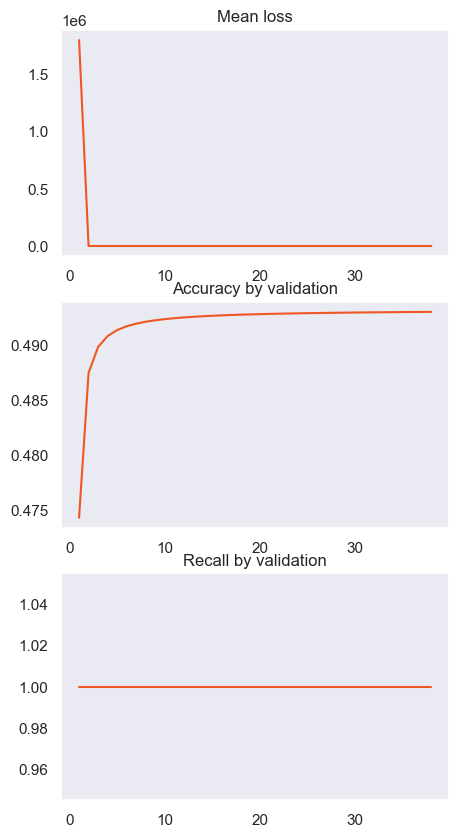

100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:15<00:00,  2.46it/s]


In [119]:
train(model, criterion, optimizer, epochs)

In [120]:
test_pred = get_prediction(model, test_loader)

In [121]:
test_pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [122]:
metrics.show_metrics(y_test.values, test_pred)

True positive rate (recall):  1.0
False positive rate:  1.0
Precision:  0.49324324324324326
Recall:  1.0
True negative rate:  0.0
ROC-AUC:  0.5
F1:  0.6606334841628959
MCC:  nan
G-mean:  0.0
